# Aula3 - Resolvendo Tarefas com LLM (Large Language Model) de Maneira Zero e Few-shot

[Unicamp - IA368DD: Deep Learning aplicado a sistemas de busca.](https://www.cpg.feec.unicamp.br/cpg/lista/caderno_horario_show.php?id=1779)

Autor: Marcus Vinícius Borela de Castro

[Repositório no github](https://github.com/marcusborela/deep_learning_em_buscas_unicamp)


[![Open In Colab latest github version](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marcusborela/deep_learning_em_buscas_unicamp/blob/main/code/aula_2_classificacao_de_texto_e_reranqueador.ipynb) [Open In Colab latest github version]

# Enunciado exercício
O aluno irá escolher uma tarefa para resolver de maneira zero ou few-shot. Sugestões:
- Classificação de textos (ex: análise de sentimos (IMDB))
- Predizer se uma passagem/parágrafo é relevante para uma pergunta/query
- Se uma resposta predita por um sistema de QA ou sumarizador é semanticamente igual à resposta ground-truth


É importante ter uma função de avaliação da qualidade das respostas do modelo few-shot. Por exemplo, acurácia.


É possível criar um pequeno dataset de teste manualmente (ex: com 10 à 100 exemplos)


- Usar a API do LLAMA fornecida por nós (licença exclusiva para pesquisa). [Colab demo da API do LLAMA](https://colab.research.google.com/drive/1zZ-ch29LTicNPA62t2MaOwMROywnqUxf?usp=sharing) (obrigado, Thales Rogério)
- Opcionalmente, usar a API do code-davinci-002, que é de graça e trás resultados muito bons.
CUIDADO: NÃO USAR O TEXT-DAVINCI-002/003, que é pago

- Opcionalmente, usar a API do ChatGPT (gpt-3.5-turbo) que é barata: ~1 centavo de real por 1000 tokens (uma página)
- Opcionalmente, usar o Alpaca: https://alpaca-ai.ngrok.io/


Dicas:
- Teste com zero-shot E few-shot.
- No few-shot, faça testes com e sem instruções no cabeçalho (explicação da tarefa, ex: "Traduza de Ingles para Portugues"). Pode ser que sem a instrução o modelo até funcione melhor.
- Siga sempre um padrão ao criar os exemplos few-shot. Aqui tem uma pagina com dicas para prompt engineering: https://help.openai.com/en/articles/6654000-best-practices-for-prompt-engineering-with-openai-api


# Organizando o ambiente

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [2]:
from psutil import virtual_memory

In [3]:
def mostra_memoria(lista_mem=['cpu']):
  """
  Esta função exibe informações de memória da CPU e/ou GPU, conforme parâmetros fornecidos.

  Parâmetros:
  -----------
  lista_mem : list, opcional
      Lista com strings 'cpu' e/ou 'gpu'. 
      'cpu' - exibe informações de memória da CPU.
      'gpu' - exibe informações de memória da GPU (se disponível).
      O valor padrão é ['cpu'].

  Saída:
  -------
  A função não retorna nada, apenas exibe as informações na tela.

  Exemplo de uso:
  ---------------
  Para exibir informações de memória da CPU:
      mostra_memoria(['cpu'])

  Para exibir informações de memória da CPU e GPU:
      mostra_memoria(['cpu', 'gpu'])
  
  Autor: Marcus Vinícius Borela de Castro

  """  
  if 'cpu' in lista_mem:
    vm = virtual_memory()
    ram={}
    ram['total']=round(vm.total / 1e9,2)
    ram['available']=round(virtual_memory().available / 1e9,2)
    # ram['percent']=round(virtual_memory().percent / 1e9,2)
    ram['used']=round(virtual_memory().used / 1e9,2)
    ram['free']=round(virtual_memory().free / 1e9,2)
    ram['active']=round(virtual_memory().active / 1e9,2)
    ram['inactive']=round(virtual_memory().inactive / 1e9,2)
    ram['buffers']=round(virtual_memory().buffers / 1e9,2)
    ram['cached']=round(virtual_memory().cached/1e9 ,2)
    print(f"Your runtime RAM in gb: \n total {ram['total']}\n available {ram['available']}\n used {ram['used']}\n free {ram['free']}\n cached {ram['cached']}\n buffers {ram['buffers']}")
    print('/nGPU')
    gpu_info = !nvidia-smi
  if 'gpu' in lista_mem:
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Not connected to a GPU')
    else:
      print(gpu_info)


In [4]:
mostra_memoria(['cpu'])

Your runtime RAM in gb: 
 total 27.33
 available 26.33
 used 0.63
 free 22.16
 cached 4.18
 buffers 0.37
/nGPU


### Vinculando pasta do google drive para salvar dados

In [5]:
import os

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Fixando as seeds

In [7]:
import random
import numpy as np
import torch

In [8]:
def inicializa_seed(num_semente:int=123):
  """
  Inicializa as sementes para garantir a reprodutibilidade dos resultados do modelo.
  Essa é uma prática recomendada, já que a geração de números aleatórios pode influenciar os resultados do modelo.
  Além disso, a função também configura as sementes da GPU para garantir a reprodutibilidade quando se utiliza aceleração por GPU. 
  
  Args:
      num_semente (int): número da semente a ser utilizada para inicializar as sementes das bibliotecas.
  
  References:
      http://nlp.seas.harvard.edu/2018/04/03/attention.html
      https://github.com/CyberZHG/torch-multi-head-attention/blob/master/torch_multi_head_attention/multi_head_attention.py#L15
  """
  # Define as sementes das bibliotecas random, numpy e pytorch
  random.seed(num_semente)
  np.random.seed(num_semente)
  torch.manual_seed(num_semente)
  
  # Define as sementes da GPU
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  #torch.cuda.manual_seed(num_semente)
  #Cuda algorithms
  #torch.backends.cudnn.deterministic = True


In [9]:
num_semente=123
inicializa_seed(num_semente)

## Preparando para debug e display

In [10]:
import pandas as pd
import os

In [11]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 94.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 18.5 MB/s eta 0:00:00


In [12]:
import transformers

Dicas em https://zohaib.me/debugging-in-google-collab-notebook/

In [13]:
!pip install -Uqq ipdb
import ipdb
# %pdb off # desativa debug em exceção
# %pdb on  # ativa debug em exceção
# ipdb.set_trace(context=8)  para execução nesse ponto

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.3/793.3 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 KB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 8.11.0 which is incompatible.


In [14]:
def config_display():
  """
  Esta função configura as opções de display do Pandas.
  """

  # Configurando formato saída Pandas
  # define o número máximo de colunas que serão exibidas
  pd.options.display.max_columns = None

  # define a largura máxima de uma linha
  pd.options.display.width = 1000

  # define o número máximo de linhas que serão exibidas
  pd.options.display.max_rows = 100

  # define o número máximo de caracteres por coluna
  pd.options.display.max_colwidth = 50

  # se deve exibir o número de linhas e colunas de um DataFrame.
  pd.options.display.show_dimensions = True

  # número de dígitos após a vírgula decimal a serem exibidos para floats.
  pd.options.display.precision = 7


In [15]:
def config_debug():
  """
  Esta função configura as opções de debug do PyTorch e dos pacotes
  transformers e datasets.
  """

  # Define opções de impressão de tensores para o modo científico
  torch.set_printoptions(sci_mode=True) 
  """
    Significa que valores muito grandes ou muito pequenos são mostrados em notação científica.
    Por exemplo, em vez de imprimir o número 0.0000012345 como 0.0000012345, 
    ele seria impresso como 1.2345e-06. Isso é útil em situações em que os valores dos tensores 
    envolvidos nas operações são muito grandes ou pequenos, e a notação científica permite 
    uma melhor compreensão dos números envolvidos.  
  """

  # Habilita detecção de anomalias no autograd do PyTorch
  torch.autograd.set_detect_anomaly(True)
  """
    Permite identificar operações que podem causar problemas de estabilidade numérica, 
    como gradientes explodindo ou desaparecendo. Quando essa opção é ativada, 
    o PyTorch verifica se há operações que geram valores NaN ou infinitos nos tensores 
    envolvidos no cálculo do gradiente. Se for detectado um valor anômalo, o PyTorch 
    interrompe a execução e gera uma exceção, permitindo que o erro seja corrigido 
    antes que se torne um problema maior.

    É importante notar que a detecção de anomalias pode ter um impacto significativo 
    no desempenho, especialmente em modelos grandes e complexos. Por esse motivo,
    ela deve ser usada com cautela e apenas para depuração.
  """

  # Configura variável de ambiente para habilitar a execução síncrona (bloqueante) das chamadas da API do CUDA.
  os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
  """
    o Python aguarda o término da execução de uma chamada da API do CUDA antes de executar a próxima chamada. 
    Isso é útil para depurar erros no código que envolve operações na GPU, pois permite que o erro seja capturado 
    no momento em que ocorre, e não depois de uma sequência de operações que pode tornar a origem do erro mais difícil de determinar.
    No entanto, é importante lembrar que esse modo de execução é significativamente mais lento do que a execução assíncrona, 
    que é o comportamento padrão do CUDA. Por isso, é recomendado utilizar esse comando apenas em situações de depuração 
    e removê-lo após a solução do problema.
  """

  # Define o nível de verbosity do pacote transformers para info
  transformers.utils.logging.set_verbosity_info() 
  
  
  """
    Define o nível de detalhamento das mensagens de log geradas pela biblioteca Hugging Face Transformers 
    para o nível info. Isso significa que a biblioteca irá imprimir mensagens de log informativas sobre
    o andamento da execução, tais como tempo de execução, tamanho de batches, etc.

    Essas informações podem ser úteis para entender o que está acontecendo durante a execução da tarefa 
    e auxiliar no processo de debug. É importante notar que, em alguns casos, a quantidade de informações
    geradas pode ser muito grande, o que pode afetar o desempenho do sistema e dificultar a visualização
    das informações relevantes. Por isso, é importante ajustar o nível de detalhamento de acordo com a 
    necessidade de cada tarefa.
  
    Caso queira reduzir a quantidade de mensagens, comentar a linha acima e 
      descomentar as duas linhas abaixo, para definir o nível de verbosity como error ou warning
  
    transformers.utils.logging.set_verbosity_error()
    transformers.utils.logging.set_verbosity_warning()
  """


  # Define o modo verbose do xmode, que é utilizado no debug
  %xmode Verbose 

  """
    Comando usado no Jupyter Notebook para controlar o modo de exibição das informações de exceções.
    O modo verbose é um modo detalhado que exibe informações adicionais ao imprimir as exceções.
    Ele inclui as informações de pilha de chamadas completa e valores de variáveis locais e globais 
    no momento da exceção. Isso pode ser útil para depurar e encontrar a causa de exceções em seu código.
    Ao usar %xmode Verbose, as informações de exceção serão impressas com mais detalhes e informações adicionais serão incluídas.

    Caso queira desabilitar o modo verbose e utilizar o modo plain, 
    comentar a linha acima e descomentar a linha abaixo:
    %xmode Plain
  """

  """
    Dica:
    1.  pdb (Python Debugger)
      Quando ocorre uma exceção em uma parte do código, o programa para a execução e exibe uma mensagem de erro 
      com informações sobre a exceção, como a linha do código em que ocorreu o erro e o tipo da exceção.

      Se você estiver depurando o código e quiser examinar o estado das variáveis ​​e executar outras operações 
      no momento em que a exceção ocorreu, pode usar o pdb (Python Debugger). Para isso, é preciso colocar o comando %debug 
      logo após ocorrer a exceção. Isso fará com que o programa pare na linha em que ocorreu a exceção e abra o pdb,
      permitindo que você explore o estado das variáveis, examine a pilha de chamadas e execute outras operações para depurar o código.


    2. ipdb
      O ipdb é um depurador interativo para o Python que oferece recursos mais avançados do que o pdb,
      incluindo a capacidade de navegar pelo código fonte enquanto depura.
      
      Você pode começar a depurar seu código inserindo o comando ipdb.set_trace() em qualquer lugar do 
      seu código onde deseja pausar a execução e começar a depurar. Quando a execução chegar nessa linha, 
      o depurador entrará em ação, permitindo que você examine o estado atual do seu programa e execute 
      comandos para investigar o comportamento.

      Durante a depuração, você pode usar comandos:
        next (para executar a próxima linha de código), 
        step (para entrar em uma função chamada na próxima linha de código) 
        continue (para continuar a execução normalmente até o próximo ponto de interrupção).

      Ao contrário do pdb, o ipdb é um depurador interativo que permite navegar pelo código fonte em que
      está trabalhando enquanto depura, permitindo que você inspecione variáveis, defina pontos de interrupção
      adicionais e até mesmo execute expressões Python no contexto do seu programa.
  """


In [16]:
config_display()

In [17]:
config_debug()

Exception reporting mode: Verbose


## Importações

In [18]:
import requests  # para Llama
import time # para Llama

In [19]:
from tqdm import tqdm

In [20]:
import string

### Import the openai library

In [21]:
# if needed, install and/or upgrade to the latest version of the OpenAI Python library
%pip install --upgrade openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 12.3 MB/s eta 0:00:00


In [22]:
# import the OpenAI Python library for calling the OpenAI API
import openai

In [23]:
%pip install --upgrade tiktoken

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.2 MB/s eta 0:00:00


In [24]:
import tiktoken

In [25]:
import getpass

In [26]:
openai.api_key = getpass.getpass("Entre a OPENAI_API_KEY")

Entre a OPENAI_API_KEY··········


## Definindo paths

In [27]:
path_data = '/content/drive/MyDrive/treinamento/202301_IA368DD/collections/squad'

# Experimentando chamadas aos LLM

## Chat GPT (Modelo gpt-3.5-turbo)

Para uso do gpt-3.5-turbo, usamos como referência o caderno da [openai: How_to_format_inputs_to_ChatGPT_models.ipynb](https://github.com/openai/openai-cookbook/blob/main/examples/How_to_format_inputs_to_ChatGPT_models.ipynb)

### How to format inputs to ChatGPT models

ChatGPT is powered by `gpt-3.5-turbo`, OpenAI's most advanced model.

You can build your own applications with `gpt-3.5-turbo` using the OpenAI API.

Chat models take a series of messages as input, and return an AI-written message as output.

This guide illustrates the chat format with a few example API calls.

### An example chat API call

A chat API call has two required inputs:
- `model`: the name of the model you want to use (e.g., `gpt-3.5-turbo`)
- `messages`: a list of message objects, where each object has at least two fields:
    - `role`: the role of the messenger (either `system`, `user`, or `assistant`)
    - `content`: the content of the message (e.g., `Write me a beautiful poem`)

Typically, a conversation will start with a system message, followed by alternating user and assistant messages, but you are not required to follow this format.

Let's look at an example chat API calls to see how the chat format works in practice.

In [ ]:
MODEL = "gpt-3.5-turbo"

In [ ]:
response = openai.ChatCompletion.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Knock knock."},
        {"role": "assistant", "content": "Who's there?"},
        {"role": "user", "content": "Marcus."},
    ],
    temperature=0,
)

In [ ]:
response


<OpenAIObject chat.completion id=chatcmpl-6w8sJPUH6CkXDCC8O0TEWzRkOuxvY at 0x7fac7482e180> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "Marcus who?",
        "role": "assistant"
      }
    }
  ],
  "created": 1679315159,
  "id": "chatcmpl-6w8sJPUH6CkXDCC8O0TEWzRkOuxvY",
  "model": "gpt-3.5-turbo-0301",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 4,
    "prompt_tokens": 38,
    "total_tokens": 42
  }
}

As you can see, the response object has a few fields:
- `id`: the ID of the request
- `object`: the type of object returned (e.g., `chat.completion`)
- `created`: the timestamp of the request
- `model`: the full name of the model used to generate the response
- `usage`: the number of tokens used to generate the replies, counting prompt, completion, and total
- `choices`: a list of completion objects (only one, unless you set `n` greater than 1)
    - `message`: the message object generated by the model, with `role` and `content`
    - `finish_reason`: the reason the model stopped generating text (either `stop`, or `length` if `max_tokens` limit was reached)
    - `index`: the index of the completion in the list of choices

Extract just the reply with:

In [ ]:
response['choices'][0]['message']['content']

'Marcus who?'

Even non-conversation-based tasks can fit into the chat format, by placing the instruction in the first user message.

For example, to ask the model to explain asynchronous programming in the style of the pirate Blackbeard, we can structure conversation as follows:

### Tips for instructing gpt-3.5-turbo-0301

Best practices for instructing models may change from model version to model version. The advice that follows applies to `gpt-3.5-turbo-0301` and may not apply to future models.

#### System messages

The system message can be used to prime the assistant with different personalities or behaviors.

However, the model does not generally pay as much attention to the system message, and therefore we recommend placing important instructions in the user message instead.

An example of a system message that primes the assistant to explain concepts in great depth

response = openai.ChatCompletion.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": "You are a friendly and helpful teaching assistant. You explain concepts in great depth using simple terms, and you give examples to help people learn. At the end of each explanation, you ask a question to check for understanding"},
        {"role": "user", "content": "Can you explain how fractions work?"},
    ],
    temperature=0,
)

print(response["choices"][0]["message"]["content"])


In [ ]:
# An example of a system message that primes the assistant to give brief, to-the-point answers
response = openai.ChatCompletion.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": "You are a laconic assistant. You reply with brief, to-the-point answers with no elaboration."},
        {"role": "user", "content": "Can you explain how fractions work?"},
    ],
    temperature=0,
)

print(response["choices"][0]["message"]["content"])


Fractions represent a part of a whole. They consist of a numerator (top number) and a denominator (bottom number) separated by a line. The numerator represents how many parts of the whole are being considered, while the denominator represents the total number of equal parts that make up the whole.


## Counting tokens OpenAI Models

Mais detalhes em [OpenAI: How_to_count_tokens_with_tiktoken.ipynb](https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb)

When you submit your request, the API transforms the messages into a sequence of tokens.

The number of tokens used affects:
- the cost of the request
- the time it takes to generate the response
- when the reply gets cut off from hitting the maximum token limit (4096 for `gpt-3.5-turbo`)

As of Mar 01, 2023, you can use the following function to count the number of tokens that a list of messages will use.

In [ ]:
# example token count from the OpenAI API
response = openai.ChatCompletion.create(
    model=MODEL,
    messages=messages,
    temperature=0,
)


In [ ]:
response

<OpenAIObject chat.completion id=chatcmpl-6w8ut6RDJgaIG4Ga5rFkaNq5BtOyZ at 0x7fad189dc180> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "This sudden change in plans means we don't have enough time to do everything for the client's project.",
        "role": "assistant"
      }
    }
  ],
  "created": 1679315319,
  "id": "chatcmpl-6w8ut6RDJgaIG4Ga5rFkaNq5BtOyZ",
  "model": "gpt-3.5-turbo-0301",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 22,
    "prompt_tokens": 126,
    "total_tokens": 148
  }
}

In [ ]:
print(f'{response["usage"]["prompt_tokens"]} prompt tokens used.')

126 prompt tokens used.


In [ ]:
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

In [ ]:
encoding.encode("tiktoken is great!")

[83, 1609, 5963, 374, 2294, 0]

In [ ]:
[encoding.decode_single_token_bytes(token) for token in [83, 1609, 5963, 374, 2294, 0]]

[b't', b'ik', b'token', b' is', b' great', b'!']

In [ ]:
def num_tokens_from_string(string: str, model_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model(model_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [ ]:
num_tokens_from_string("tiktoken is great!", "gpt-3.5-turbo")

6

## code-davinci-002

Para uso do code-davinci-00, usamos como referência o caderno da [openai: Unit_test_writing_using_a_multi-step_prompt.ipynb](https://github.com/openai/openai-cookbook/blob/main/examples/Unit_test_writing_using_a_multi-step_prompt.ipynb)

Dicas para iteração com esse modelo em https://platform.openai.com/docs/guides/code/best-practices

In [ ]:
MODEL = "code-davinci-002"

In [ ]:
prompt_teste = 'Write a function in python that calculates fibonacci'

In [ ]:
max_tokens:int = 1000
temperature:float = 1.0

In [ ]:
response = openai.Completion.create(
        model=MODEL,
        prompt=prompt_teste,
        stop=["\n\n", "\n\t\n", "\n    \n", "```"],
        max_tokens=max_tokens,
        temperature=temperature,
        stream=False)

In [ ]:
response

<OpenAIObject text_completion id=cmpl-6vwsEdg2uKVnloyeSQezXvG21ODqQ at 0x7ff7ac25ac70> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "text": " series up to n\nAnd sum it up (optional)\nAll for this Fibonacci number challenge feature on https://dev.to\nUpdate July 2019: fix a bug when n is 0\n<code>def fibonacci(n):\nf0 = 0;\nf1 = 1;\nseries = {}\nsum_series = 0\nj = 1;"
    }
  ],
  "created": 1679269026,
  "id": "cmpl-6vwsEdg2uKVnloyeSQezXvG21ODqQ",
  "model": "code-davinci-002",
  "object": "text_completion",
  "usage": {
    "completion_tokens": 78,
    "prompt_tokens": 10,
    "total_tokens": 88
  }
}

In [ ]:
prompt_teste = 'Meu nome é Marcus. Moro no Brasil. A capital do Brasil é: '

In [ ]:
response = openai.Completion.create(
        model=MODEL,
        prompt=prompt_teste,
        stop=["\n\n", "\n\t\n", "\n    \n", "```"],
        max_tokens=10,
        temperature=temperature,
        stream=False)

In [ ]:
response

<OpenAIObject text_completion id=cmpl-6vwrqVbXKVNNyOCsaqyiKk3Z0yxxA at 0x7ff733ecf040> JSON: {
  "choices": [
    {
      "finish_reason": "length",
      "index": 0,
      "logprobs": null,
      "text": "${heroi.name}.\nEle parte"
    }
  ],
  "created": 1679269002,
  "id": "cmpl-6vwrqVbXKVNNyOCsaqyiKk3Z0yxxA",
  "model": "code-davinci-002",
  "object": "text_completion",
  "usage": {
    "completion_tokens": 10,
    "prompt_tokens": 20,
    "total_tokens": 30
  }
}

## LLAMA 

[Colab demo da API do LLAMA](https://colab.research.google.com/drive/1zZ-ch29LTicNPA62t2MaOwMROywnqUxf?usp=sharing) (obrigado, Thales Rogério)

In [ ]:
base_url="http://143.106.167.108/api"

In [ ]:
data={
	"prompt":"""Given table, specify which rows have repeated values for both "Item number" and "Local". If no row is repeated say "no repeats".

Example 1:
|Row | Item number | Local |
|1 |  3 5 7 | New York |
|2|  5 8 2 | Madagascar |
|3|  3 4 5 | New York |
|4|  3 4 5 | Paris |

Explanation: Rows 1 and 3 have the same local "New York" and the same item number "3 4 5". Therefore they are repeated.

Answer: (1,3).

Example 2:
|Row | Item number | Local |
|1 |  0 9 2 4 | Amsterdam |
|2|  9 4 2 4 | Barcelona |
|3|  7 3 2 | London |
|4|  7 3 1 | London |
|5|  7 3 2 | London |
|6|  7 3 2 | London |
|7|  7 3 2 | London |
|8|  7 3  2 |  New York |
|9 |  0 9 2 4 | Amsterdam |

Explanation:""",

"temperature": 0.0,
"top_p": 1,
"max_length": 250
}

r=requests.post(f"{base_url}/complete", json=data)

In [ ]:
if r.ok:
  response=r.json()
  print(response)

{'prompt': 'Given table, specify which rows have repeated values for both "Item number" and "Local". If no row is repeated say "no repeats".\n\nExample 1:\n|Row | Item number | Local |\n|1 |  3 5 7 | New York |\n|2|  5 8 2 | Madagascar |\n|3|  3 4 5 | New York |\n|4|  3 4 5 | Paris |\n\nExplanation: Rows 1 and 3 have the same local "New York" and the same item number "3 4 5". Therefore they are repeated.\n\nAnswer: (1,3).\n\nExample 2:\n|Row | Item number | Local |\n|1 |  0 9 2 4 | Amsterdam |\n|2|  9 4 2 4 | Barcelona |\n|3|  7 3 2 | London |\n|4|  7 3 1 | London |\n|5|  7 3 2 | London |\n|6|  7 3 2 | London |\n|7|  7 3 2 | London |\n|8|  7 3  2 |  New York |\n|9 |  0 9 2 4 | Amsterdam |\n\nExplanation:', 'temperature': 0.0, 'top_p': 1.0, 'max_length': 250, 'stopping_tokens': [], 'request_uuid': '403647f2-fd6d-40e6-a21c-098ea4870703'}


In [ ]:
response

{'prompt': 'Given table, specify which rows have repeated values for both "Item number" and "Local". If no row is repeated say "no repeats".\n\nExample 1:\n|Row | Item number | Local |\n|1 |  3 5 7 | New York |\n|2|  5 8 2 | Madagascar |\n|3|  3 4 5 | New York |\n|4|  3 4 5 | Paris |\n\nExplanation: Rows 1 and 3 have the same local "New York" and the same item number "3 4 5". Therefore they are repeated.\n\nAnswer: (1,3).\n\nExample 2:\n|Row | Item number | Local |\n|1 |  0 9 2 4 | Amsterdam |\n|2|  9 4 2 4 | Barcelona |\n|3|  7 3 2 | London |\n|4|  7 3 1 | London |\n|5|  7 3 2 | London |\n|6|  7 3 2 | London |\n|7|  7 3 2 | London |\n|8|  7 3  2 |  New York |\n|9 |  0 9 2 4 | Amsterdam |\n\nExplanation:',
 'temperature': 0.0,
 'top_p': 1.0,
 'max_length': 250,
 'stopping_tokens': [],
 'request_uuid': '403647f2-fd6d-40e6-a21c-098ea4870703'}

We will use the request_uuid to check if the completion job is done

In [ ]:
request_uuid=response["request_uuid"]

In [ ]:
import time

In [ ]:
ready = False
while not ready:
    r = requests.get(f"{base_url}/get_result/{request_uuid}")
    response = r.json()
    ready = response['ready']
    if ready:
        print(response['generated_text'])
        break
    # Wait 10 seconds before checking again
    print(f"Aguardando 10 segundos")
    time.sleep(10)


 Rows 3-7 all have the same local "London", but their item numbers differ. Therefore there are no repeats in this example.


when consulting the result you may find 3 scenarios
- Your job did not run yet, you should try again in a couple of seconds (Ready=False, message=None)
- Your job did run and everything worked (Ready=True, message=your response)
- Your job did run but it failed (Ready=True, message=None)

### Rate limiting

We may adjust this during the week, but due to computational constrains we will apply a rate limit of about 2 requests per 5 seconds. If you exceed this limit you will receive an error 429. You should adjust your code accordingly.

Please remember that the whole class is using a shared resource, so avoid excessive requests even if they are under the rate limit.

If you encounter any errors or problems, let us know in the classroom.

In [ ]:
for i in range(30):
  r=requests.get(f"{base_url}/get_result/{request_uuid}")
  print(i, "->", r.status_code)

0 -> 200
1 -> 200
2 -> 200
3 -> 429
4 -> 429
5 -> 429
6 -> 429
7 -> 429
8 -> 429
9 -> 429
10 -> 429
11 -> 429
12 -> 200
13 -> 429
14 -> 429
15 -> 429
16 -> 429
17 -> 429
18 -> 429
19 -> 429
20 -> 429
21 -> 429
22 -> 429
23 -> 200
24 -> 429
25 -> 429
26 -> 429
27 -> 429
28 -> 429
29 -> 429


In [ ]:
# tokenizer = transformers.AutoTokenizer.from_pretrained("decapoda-research/llama-7b-hf-int4")
# llama-7b-hf, llama-65b-hf, llama-smallint-pt, llama-13b-hf-int4, llama-7b-hf-int4

# Definindo classes LLM_Model 

Para abstrair os detalhes de cada modelo

LLM_Openai_Model_QA - classe mãe de modelos OpenAi

In [ ]:
class LLM_OpenAi_Model_QA:
    def __init__(self, name:str, max_tokens:int, temperature:int=0, top_p:int=1):
        """
        Inicializa um novo objeto LLM_Model_QA.
        temperature = 0 (determinístico: sempre mesma saída para mesma entrada)
        """
        self.name = name
        self.max_tokens = max_tokens
        self.temperature = temperature
        self.top_p = top_p
        # self.stop=[".", "\n","\n\n", "\n\t\n", "\n    \n", "```"]
        # Up to 4 sequences where the API will stop generating further tokens
        self.stop=[".", "\n", "!", "```"]
        self.max_tokens_resposta = 30       
        self.encoding = tiktoken.encoding_for_model(self.name)
        self.qtd_tokens_fixa = 0

    def run_one_question(self, parm_prompt:str, parm_max_len_output:bool)->tuple:
        pass

    def answer_one_question(self, parm_prompt:str, parm_max_len_output:bool=None)->str:
        answer, _ = self.run_one_question(parm_prompt, parm_max_len_output)
        return answer

    def assert_limite_respeitado(self, parm_text:str, tamanho_max_resposta):
        tamanho_prompt = self.conta_token(parm_text)
        total_uso = tamanho_prompt + tamanho_max_resposta + self.qtd_tokens_fixa
        if (tamanho_prompt + tamanho_max_resposta + self.qtd_tokens_fixa) >  self.max_tokens:
            raise Exception(f"tamanho_prompt {tamanho_prompt} + tamanho_max_resposta {tamanho_max_resposta} + self.qtd_tokens_fixa {self.qtd_tokens_fixa} >  self.max_tokens :: {total_uso}  > {self.max_tokens}")

    def conta_token(self, parm_text:str):
        """
        Retorna o número de tokens do texto conforme tokenizador do modelo
        """
        qtd_token = len(self.encoding.encode(parm_text))
        return qtd_token

In [ ]:
class ChatGPT_LLM_Model_QA(LLM_OpenAi_Model_QA):
    # custo em 20/3/2023: $0.002 / 1K tokens
    def __init__(self, parm_temperature:int=0, parm_top_p:int=1):
        super().__init__(name="gpt-3.5-turbo", max_tokens=4096, temperature=parm_temperature, top_p=parm_top_p)
        # calculo do número de tokens usadas:
        qtd_tokens_fixa = 0
        qtd_tokens_fixa += 4  # every message follows <im_start>{role/name}\n{content}<im_end>\n
        qtd_tokens_fixa += 2  # every reply is primed with <im_start>assistant
        qtd_tokens_fixa += self.conta_token('system') 
        qtd_tokens_fixa += self.conta_token('user')         
        qtd_tokens_fixa += self.conta_token('You are an assistant who will help me answer questions.') 
        self.qtd_tokens_fixa = qtd_tokens_fixa


    def run_one_question(self, parm_prompt:str, parm_max_len_output:int=None)->tuple:
        """
        Chama o modelo passando parm_prompt
        """
        if parm_max_len_output is None:
            tamanho_max_resposta = self.max_tokens_resposta
        else:
            tamanho_max_resposta = parm_max_len_output
            
        super().assert_limite_respeitado(parm_prompt, tamanho_max_resposta)

        response = openai.ChatCompletion.create(
            model=self.name,
            messages=[
                {"role": "system", "content": "You are an assistant who will help me answer questions."},
                {"role": "user", "content": parm_prompt},
            ],
            temperature=self.temperature,
            top_p = self.top_p,
            n =  1,
            # stop = self.stop,
            max_tokens = tamanho_max_resposta,
            stream=False
        )
        resposta = response.choices[0].message.content  
        return resposta, response
    

In [ ]:
class Code_davinci_LLM_Model_QA(LLM_OpenAi_Model_QA):
    # custo em 20/3/2023: gratuito
    def __init__(self, parm_temperature:int=0, parm_top_p:int=1):
        super().__init__(name="code-davinci-002", max_tokens=8001, temperature=parm_temperature, top_p=parm_top_p)

    def run_one_question(self, parm_prompt:str,parm_max_len_output:int=None)->tuple:
        """
        Chama o modelo passando parm_prompt
        """
        if parm_max_len_output is None:
            tamanho_max_resposta = self.max_tokens_resposta
        else:
            tamanho_max_resposta = parm_max_len_output

        super().assert_limite_respeitado(parm_prompt, tamanho_max_resposta)

        response = openai.Completion.create(
            model=self.name,
            prompt= parm_prompt,
            stop = self.stop,
            temperature=self.temperature,
            top_p = self.top_p,
            # n =  1,
            max_tokens = tamanho_max_resposta,
            # stream=False
            )
        resposta = response.choices[0].text
        return resposta, response
    

In [ ]:
class Llama_LLM_Model_QA():
    """
    Apoio código do Thales
    Mais sobre o modelo: https://github.com/facebookresearch/llama/blob/main/MODEL_CARD.md
    """

    def __init__(self, parm_temperature:int=0, parm_top_p:int=1):
        
        self.max_tokens_resposta = 30
        self.name = 'llama'
        # limite 2048 obtido em https://huggingface.co/decapoda-research/llama-65b-hf/blob/main/config.json
        self.max_tokens = 2048
        self.temperature = parm_temperature
        self.top_p = parm_top_p
        self.stop=[".", "\n", "!", "```"]
        self.max_tokens_resposta = 30
        self.tempo_espera = 10

    def answer_one_question(self, parm_prompt:str, parm_max_len_output:int=None):
        """
        Chama o modelo passando parm_prompt
        """
        if parm_max_len_output is None:
            tamanho_max_resposta = self.max_tokens_resposta
        else:
            tamanho_max_resposta = parm_max_len_output

        base_url="http://143.106.167.108/api"
        data={
            "prompt":parm_prompt,
            "temperature": self.temperature,
            "top_p": self.top_p,
            "stop": self.stop,
            "max_length": tamanho_max_resposta
          }
          #register completion
        while 1:
            r=requests.post(f"{base_url}/complete", json=data)
            if r.status_code==429:
              print(f"Esperando no 'complete' {self.tempo_espera} devido a erro 429")
              time.sleep(self.tempo_espera)
              continue
            break

        if r.ok:
            response=r.json()
            request_uuid=response["request_uuid"]
            print(f"Esperando antes do primeiro 'get_result' {self.tempo_espera} devido a erro 429")
            time.sleep(self.tempo_espera)
            while 1:
              r=requests.get(f"{base_url}/get_result/{request_uuid}")
              if r.status_code==429:
                print(f"Esperando em outros 'get_result' {self.tempo_espera} devido a erro 429")
                time.sleep(self.tempo_espera)
                continue

              response=r.json()
              if response["ready"]==False:
                print(f"Llama Response not ready após 'get_result' {self.tempo_espera} sem erro 429")
                time.sleep(self.tempo_espera)
                continue

              if response["ready"] and response["generated_text"] == None:
                raise ValueError(f"something went wrong with llama call with data {data}")
              return response["generated_text"]
        else:
            r.raise_for_status()


        resposta = response["generated_text"] 
        return resposta, response

    def conta_token(self, parm_text:str):
        """
        Retorna o número de tokens do texto conforme tokenizador do modelo
        """
        raise Exception(f"Não descobri qual tokenizador usado pelo Llama")     

### Exemplo de APIErro esporádico no OpenAI

APIError: The server had an error processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if you keep seeing this error. (Please include the request ID f9af83d5f361d8dddc598de67bb86735 in your email.) 

{
  "error": {
    "message": "The server had an error processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if you keep seeing this error. (Please include the request ID f9af83d5f361d8dddc598de67bb86735 in your email.)",
    "type": "server_error",
    "param": null,
    "code": null
  }


}
 500 {'error': {'message': 'The server had an error processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if you keep seeing this error. (Please include the request ID f9af83d5f361d8dddc598de67bb86735 in your email.)', 'type': 'server_error', 'param': None, 'code': None}} {'Date': 'Sun, 19 Mar 2023 23:06:26 GMT', 'Content-Type': 'application/json', 'Content-Length': '366', 'Connection': 'keep-alive', 'Access-Control-Allow-Origin': '*', 'Openai-Model': 'gpt-3.5-turbo-0301', 'Openai-Organization': 'user-0jnhur9aytg48d9jerr2jcsu', 'Openai-Processing-Ms': '669', 'Openai-Version': '2020-10-01', 'Strict-Transport-Security': 'max-age=15724800; includeSubDomains', 'X-Ratelimit-Limit-Requests': '3500', 'X-Ratelimit-Remaining-Requests': '3499', 'X-Ratelimit-Reset-Requests': '17ms', 'X-Request-Id': 'f9af83d5f361d8dddc598de67bb86735'}

# Carga dos dados

Parte dos códigos nesse caderno (tratamento de dados e cálculo de métrica) foi obtido do projeto 

[exqa-complearning Extractive Q&A - Performance Comparison between Learning Methods: Context and Transfer](https://github.com/marcusborela/exqa-complearning)

Final Project at Discipline IA025, Introdução ao Aprendizado Profundo, Turma A  
Authors: Leonardo Augusto da Silva Pacheco e Marcus Vinícius Borela de Castro   
Teachers: Roberto de Alencar Lotufo e Rodrigo Frassetto Nogueira 

In [ ]:
path_squad = f'{path_data}/dev-v1.1.json'

In [ ]:
%%time
if not os.path.exists(path_data):
  os.makedirs(path_data)
  print('pasta criada')
if not os.path.exists(f'{path_data}/dev-v1.1.json'):
  !wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json -P {path_data}
  print("Dados carregados!")
else:
  print("Dados já existiam!")    

Dados já existiam!
CPU times: user 7.58 ms, sys: 0 ns, total: 7.58 ms
Wall time: 1.28 s


In [ ]:
assert os.path.exists(path_squad), f"Arquivo de dados {path_squad} não criada!"

In [ ]:
import json

In [ ]:
with open(path_squad) as dataset_file:
    nested_json = json.load(dataset_file)


In [ ]:
nested_json.keys()

dict_keys(['data', 'version'])

In [ ]:
def _convert_json_in_dataset(parm_nested_json):

    # Iterating through the json list
    entry_list = list()

    for row in nested_json['data']:
        # print(row)
        title = row['title']

        for paragraph in row['paragraphs']:
            context = paragraph['context']

            for qa in paragraph['qas']:
                entry = {}

                qa_id = qa['id']
                question = qa['question']
                answers = qa['answers']

                entry['id'] = qa_id
                entry['title'] = title.strip()
                entry['context'] = context.strip()
                entry['question'] = question.strip()

                answer_starts = [answer["answer_start"] for answer in answers]
                answer_texts = [answer["text"].strip() for answer in answers]

                entry['answer_start'] = answer_starts
                entry['answer_text'] = answer_texts

                entry_list.append(entry)
    df = pd.DataFrame(entry_list)
    return df


In [ ]:
df = _convert_json_in_dataset(nested_json)

In [ ]:
df.shape

(10570, 6)

In [ ]:
def define_question_type(line):
    line = line.lower()
    list_words = line.split()
    first_word = list_words[0]
    first_2_word = list_words[0] + ' ' + list_words[1]
    type_question = 'unknown'
    if first_2_word in question_types_2_words:
        type_question = first_2_word
    elif first_word in question_types:
            type_question = first_word
    if type_question == 'unknown':
        for type_question_punct in question_types_2_words_punctuation:
            if type_question_punct in line:
                type_question = question_types_2_words_punctuation[type_question_punct]
                break
    if type_question == 'unknown':
        for type_question_punct in question_types_punctuation:
            if type_question_punct in line:
                type_question = question_types_punctuation[type_question_punct]
                break
    return type_question

def add_punctuation_before_word_in_list(list_word):
    new_dict = {}
    for word in list_word:
        new_dict[', ' + word] = word
        new_dict[',' + word] = word
        new_dict['.' + word] = word
        new_dict['. ' + word] = word
    return new_dict

question_types = ["are", "did", "does", "do", "is", "how", "since",  "was", "were", "what", "when", "where", "who", "which", "why" ]
question_types_2_words = ["are there", "is there" ]
question_types_punctuation = add_punctuation_before_word_in_list(question_types)
question_types_2_words_punctuation = add_punctuation_before_word_in_list(question_types_2_words)

In [ ]:
df.head(4)

,id,title,context,question,answer_start,answer_text
0,56be4db0acb8001400a502ec,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,"[177, 177, 177]","[Denver Broncos, Denver Broncos, Denver Broncos]"
1,56be4db0acb8001400a502ed,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,"[249, 249, 249]","[Carolina Panthers, Carolina Panthers, Carolin..."
2,56be4db0acb8001400a502ee,Super_Bowl_50,Super Bowl 50 was an American football game to...,Where did Super Bowl 50 take place?,"[403, 355, 355]","[Santa Clara, California, Levi's Stadium, Levi..."
3,56be4db0acb8001400a502ef,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team won Super Bowl 50?,"[177, 177, 177]","[Denver Broncos, Denver Broncos, Denver Broncos]"


Aumentando as colunas do dataframe para seleção de registros

In [ ]:
df['len_context'] = df['context'].apply(len)
df['len_question'] = df['question'].apply(len)

In [ ]:
df['type_question'] = df['question'].apply(define_question_type)

In [ ]:
df['qtd_dif_resposta'] = df['answer_text'].apply(lambda x: len(set(x)))

In [ ]:
df['len_answer'] = df['answer_text'].apply(lambda x: len(x[0]))

In [ ]:
df.head(4)

,id,title,context,question,answer_start,answer_text,len_context,len_question,type_question,qtd_dif_resposta,len_answer
0,56be4db0acb8001400a502ec,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,"[177, 177, 177]","[Denver Broncos, Denver Broncos, Denver Broncos]",775,52,which,1,14
1,56be4db0acb8001400a502ed,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,"[249, 249, 249]","[Carolina Panthers, Carolina Panthers, Carolin...",775,52,which,1,17
2,56be4db0acb8001400a502ee,Super_Bowl_50,Super Bowl 50 was an American football game to...,Where did Super Bowl 50 take place?,"[403, 355, 355]","[Santa Clara, California, Levi's Stadium, Levi...",775,35,where,3,23
3,56be4db0acb8001400a502ef,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team won Super Bowl 50?,"[177, 177, 177]","[Denver Broncos, Denver Broncos, Denver Broncos]",775,33,which,1,14


In [ ]:
df = df.sort_values(by=['len_context', 'len_question', 'len_answer'], ascending=[True, True, False])

In [ ]:
df.head(5)

,id,title,context,question,answer_start,answer_text,len_context,len_question,type_question,qtd_dif_resposta,len_answer
1491,56e1011ecd28a01900c6740c,Nikola_Tesla,"On 7 January 1900, Tesla left Colorado Springs...",What happened to his lab?,"[65, 77, 77]","[His lab was torn down, torn down, torn down i...",157,25,what,3,21
1492,56e1011ecd28a01900c6740d,Nikola_Tesla,"On 7 January 1900, Tesla left Colorado Springs...",When was his lab destroyed?,"[90, 90, 90]","[1904, 1904, 1904]",157,27,when,1,4
1490,56e1011ecd28a01900c6740b,Nikola_Tesla,"On 7 January 1900, Tesla left Colorado Springs...",When did Tesla depart from Colorado Springs?,"[13, 0, 3]","[1900, On 7 January 1900, 7 January 1900]",157,44,when,3,4
1493,56e1011ecd28a01900c6740e,Nikola_Tesla,"On 7 January 1900, Tesla left Colorado Springs...",What happened to the things inside the lab aft...,"[118, 118, 118]","[sold, sold, sold two years later]",157,66,what,2,4
2611,56f8ca289b226e1400dd1007,Martin_Luther,A piece of paper was later found on which Luth...,What was later discovered written by Luther?,"[61, 61, 65]","[his last statement, his last statement, last ...",158,44,what,2,18


In [ ]:
df.groupby('type_question').size().reset_index(name='total')


,type_question,total
0,are,4
1,are there,2
2,did,7
3,do,3
4,does,4
5,how,1122
6,is,12
7,since,13
8,unknown,1557
9,was,12


In [ ]:
df.groupby('qtd_dif_resposta').size().reset_index(name='total')

,qtd_dif_resposta,total
0,1,4945
1,2,4051
2,3,1368
3,4,166
4,5,40


No trabalho citado, modelos com context-learn alcançaram bons resultados com perguntas do tipo who e what. Logo, filtrarei pore essas. 

In [ ]:
df.query("qtd_dif_resposta == 1 and type_question in ['who', 'what']").shape

(2813, 11)

# Seleção de queries

In [ ]:
df_selecao = df.query("qtd_dif_resposta == 1 and type_question in ['who', 'what'] and len_answer > 12")

In [ ]:
df_selecao

,id,title,context,question,answer_start,answer_text,len_context,len_question,type_question,qtd_dif_resposta,len_answer
121,56beb03c3aeaaa14008c920d,Super_Bowl_50,The league eventually narrowed the bids to thr...,What site is located in the San Francisco Bay ...,"[153, 153, 153]","[Levi's Stadium, Levi's Stadium, Levi's Stadium]",168,51,what,1,14
131,56d98db6dc89441400fdb552,Super_Bowl_50,The league eventually narrowed the bids to thr...,What Florida stadium was considered for Super ...,"[102, 102, 102]","[Sun Life Stadium, Sun Life Stadium, Sun Life ...",168,54,what,1,16
128,56d6ee6e0d65d21400198256,Super_Bowl_50,The league eventually narrowed the bids to thr...,What is the name of the stadium in Miami that ...,"[102, 102, 102]","[Sun Life Stadium, Sun Life Stadium, Sun Life ...",168,61,what,1,16
120,56beb03c3aeaaa14008c920b,Super_Bowl_50,The league eventually narrowed the bids to thr...,What venue in Miami was a candidate for the si...,"[102, 102, 102]","[Sun Life Stadium, Sun Life Stadium, Sun Life ...",168,66,what,1,16
124,56bf3c633aeaaa14008c9582,Super_Bowl_50,The league eventually narrowed the bids to thr...,What was the given name of Miami's stadium at ...,"[102, 102, 102]","[Sun Life Stadium, Sun Life Stadium, Sun Life ...",168,72,what,1,16
...,...,...,...,...,...,...,...,...,...,...,...
2121,56e77a8700c9c71400d7718e,Teacher,"In the past, teachers have been paid relativel...",What website are teachers using to sell their ...,"[2142, 2142, 2142]","[TeachersPayTeachers.com, TeachersPayTeachers....",2166,59,what,1,23
4197,57269bb8708984140094cb97,European_Union_law,Although it is generally accepted that EU law ...,What type of company is Van Gend en Loos?,"[487, 487, 487]","[a postal company, a postal company, a postal ...",2239,41,what,1,16
4259,5726b58f5951b619008f7b59,European_Union_law,"While the concept of a ""social market economy""...",What entity has taken the view that the goals ...,"[2135, 2135, 2135]","[the Court of Justice, the Court of Justice, t...",2302,119,what,1,20
4182,57265e455951b619008f70bd,European_Union_law,"Since its founding, the EU has operated among ...",What were the years two Regulations that confl...,"[2214, 2214, 2214, 2214]","[1964 and 1968, 1964 and 1968, 1964 and 1968, ...",2820,109,what,1,13


In [ ]:
df_selecao.groupby('type_question').size().reset_index(name='total')

,type_question,total
0,what,1103
1,who,329


In [ ]:
df_selecao = df_selecao.groupby('type_question').head(30)

In [ ]:
df_selecao.groupby('type_question').size().reset_index(name='total')


,type_question,total
0,what,30
1,who,30


In [ ]:
df_selecao.groupby('len_context').size().reset_index(name='total')


,len_context,total
0,168,6
1,181,4
2,187,3
3,188,2
4,198,1
5,199,1
6,206,3
7,217,2
8,220,1
9,233,2


In [ ]:
df_selecao.columns

Index(['id', 'title', 'context', 'question', 'answer_start', 'answer_text', 'len_context', 'len_question', 'type_question', 'qtd_dif_resposta', 'len_answer'], dtype='object')

In [ ]:
df_selecao.to_csv(f'{path_data}/df_selecao_pergunta.csv')

# Engenharia de Prompt


[Exemplos de prompt](https://platform.openai.com/examples) 


In [ ]:
instrucao = 'Instruction: Based on the text below, answer the question succinctly, using some passage present in the text, avoiding repeating words from the question\n\n'
exemplo1 = 'Example:\n\nText: Manoel was born in 1980. His friend Mauricio has worked at TCU since 1996.\n\nQuestion: Who was born in 1980?\nAnswer: Manoel.\n\n'
exemplo2 = 'Example:\n\nText: Manoel was born in 1980. His friend Mauricio has worked at TCU since 1996.\n\nQuestion: Who was born in 1980?\nAnswer: Manoel.\n\nText: Joel has worked at TCU since 2005 and was born in 1980.\n\nQuestion: Where Joel work?\nAnswer: TCU.\n\n'
texto_questao_resposta = 'Text: {context}\n\nQuestion: {question}\nAnswer:'


In [ ]:
dict_prompt_format ={
0: {"prompt": instrucao + texto_questao_resposta},
1: {"prompt": instrucao + exemplo1 + texto_questao_resposta},
2: {"prompt": instrucao + exemplo2 + texto_questao_resposta},
}

In [ ]:
lista_pergunta = [
    {'id':0,
     'text': 'In the morning there were 2 birds on my window. The weather was sunny. Unfortunately my cat Ton killed one of the birds.',
     'question': 'What animal killed a bird?', 
     'answer': ['Ton.', 'The cat Ton.']}
]

In [ ]:
prompt_teste = instrucao + ' ' + lista_pergunta[0]['text']+ ' ' + lista_pergunta[0]['question']

In [ ]:
prompt_teste

'Instruction: Based on the text below, answer the question succinctly, using some passage present in the text, avoiding repeating words from the question\n\n In the morning there were 2 birds on my window. The weather was sunny. Unfortunately my cat Ton killed one of the birds. What animal killed a bird?'

## Aplicação do Prompt

In [ ]:
def retorna_prompt(cod_prompt: int, texto_pergunta: str, texto_contexto: str) -> str:
    """
    Retorna texto_questao_resposta substituindo os parâmetros em
    'Text:{context}\n\nQuestion:{question}\nAnswer:'
    """
    global dict_prompt_format
    assert isinstance(texto_pergunta, str), f"Expected just one question, not {type(texto_pergunta)}"
    assert isinstance(texto_contexto, str), f"Expected just one context, not {type(texto_contexto)}"
    assert isinstance(cod_prompt, int), f"Expected just one context, not {type(cod_prompt)}"
    prompt = dict_prompt_format[cod_prompt]['prompt'].replace('{context}', texto_contexto).replace('{question}', texto_pergunta)
    return prompt

Experimentando para subconjunto

In [ ]:
for ndx, row in df_selecao.iloc[2:4].iterrows():
  prompt_aux = retorna_prompt(cod_prompt=0, texto_pergunta=row['question'], texto_contexto=row['context'])
  print(prompt_aux)
  break

Instruction: Based on the text below, answer the question succinctly, using some passage present in the text, avoiding repeating words from the question

Text:The league eventually narrowed the bids to three sites: New Orleans' Mercedes-Benz Superdome, Miami's Sun Life Stadium, and the San Francisco Bay Area's Levi's Stadium.

Question:What is the name of the stadium in Miami that was considered?
Answer:


In [ ]:
code_davinci_model = Code_davinci_LLM_Model_QA()
llama_model = Llama_LLM_Model_QA()
chatgpt_model = ChatGPT_LLM_Model_QA()

In [ ]:
code_davinci_model.answer_one_question(prompt_aux)

' Sun Life Stadium'

In [ ]:
code_davinci_model.run_one_question(prompt_aux)

(' Sun Life Stadium',
 <OpenAIObject text_completion id=cmpl-6wMHUBU2TCAZzxzHZxGTBPYt02nFO at 0x7fd4fe5394a0> JSON: {
   "choices": [
     {
       "finish_reason": "stop",
       "index": 0,
       "logprobs": null,
       "text": " Sun Life Stadium"
     }
   ],
   "created": 1679366692,
   "id": "cmpl-6wMHUBU2TCAZzxzHZxGTBPYt02nFO",
   "model": "code-davinci-002",
   "object": "text_completion",
   "usage": {
     "completion_tokens": 4,
     "prompt_tokens": 89,
     "total_tokens": 93
   }
 })

In [ ]:
llama_model.run_one_question(prompt_aux)

Esperando antes do primeiro 'get_result' 10 devido a erro 429
Llama Response not ready após 'get_result' 10 sem erro 429
Llama Response not ready após 'get_result' 10 sem erro 429
Llama Response not ready após 'get_result' 10 sem erro 429
Llama Response not ready após 'get_result' 10 sem erro 429
Llama Response not ready após 'get_result' 10 sem erro 429


"Sun life stadium\n\nComment: I don't understand what you are asking here.  Are you looking for a way to extract the"

In [ ]:
chatgpt_model.answer_one_question(prompt_aux)

'The stadium in Miami that was considered is called Sun Life Stadium.'

In [ ]:
chatgpt_model.run_one_question(prompt_aux)

('The stadium in Miami that was considered is called Sun Life Stadium.',
 <OpenAIObject chat.completion id=chatcmpl-6wMHZ1EQdodvNhuQu96ZKoaBa4K68 at 0x7fd4ff325db0> JSON: {
   "choices": [
     {
       "finish_reason": "stop",
       "index": 0,
       "message": {
         "content": "The stadium in Miami that was considered is called Sun Life Stadium.",
         "role": "assistant"
       }
     }
   ],
   "created": 1679366697,
   "id": "chatcmpl-6wMHZ1EQdodvNhuQu96ZKoaBa4K68",
   "model": "gpt-3.5-turbo-0301",
   "object": "chat.completion",
   "usage": {
     "completion_tokens": 14,
     "prompt_tokens": 106,
     "total_tokens": 120
   }
 })

In [ ]:
chatgpt_model.run_one_question(prompt_aux)

('The stadium in Miami that was considered is called Sun Life Stadium.',
 <OpenAIObject chat.completion id=chatcmpl-6wMBBFH2ceEq28SHHsrCdlbaOZNrH at 0x7fd4ff9aea90> JSON: {
   "choices": [
     {
       "finish_reason": "stop",
       "index": 0,
       "message": {
         "content": "The stadium in Miami that was considered is called Sun Life Stadium.",
         "role": "assistant"
       }
     }
   ],
   "created": 1679366301,
   "id": "chatcmpl-6wMBBFH2ceEq28SHHsrCdlbaOZNrH",
   "model": "gpt-3.5-turbo-0301",
   "object": "chat.completion",
   "usage": {
     "completion_tokens": 14,
     "prompt_tokens": 106,
     "total_tokens": 120
   }
 })

# Execuções

In [ ]:
dict_modelo = {'Code_DaVinci':code_davinci_model,
               'LLaMa': llama_model,
               #'chatgpt': chatgpt_model
                }

In [ ]:
lista_resposta = []
lista_erro = []
for nome_modelo, modelo in dict_modelo.items():
  for cod_prompt in [0, 1, 2]:
    for ndx, row in df_selecao.reset_index().iterrows():
      try:
        prompt_aux = retorna_prompt(cod_prompt=cod_prompt, texto_pergunta=row['question'], texto_contexto=row['context'])
        resposta = modelo.answer_one_question(prompt_aux)
        resultado = (row['id'], cod_prompt, nome_modelo, resposta)
        print(f'ndx {ndx} {row["question"]} {resultado}')
        lista_resposta.append(resultado)
        time.sleep(20)
      except Exception as e:
        print(f'Erro em ndx {ndx} id: {row["id"]} nome_modelo: {nome_modelo} cod_prompt: {cod_prompt}')
        print(f'Erro: {e}')
        lista_erro.append((row["id"], cod_prompt, nome_modelo))
        continue        

ndx 0 What site is located in the San Francisco Bay Area? ('56beb03c3aeaaa14008c920d', 0, 'Code_DaVinci', " Levi's Stadium")
ndx 1 What Florida stadium was considered for Super Bowl 50? ('56d98db6dc89441400fdb552', 0, 'Code_DaVinci', ' Sun Life Stadium')
ndx 2 What is the name of the stadium in Miami that was considered? ('56d6ee6e0d65d21400198256', 0, 'Code_DaVinci', ' Sun Life Stadium')
ndx 3 What venue in Miami was a candidate for the site of Super Bowl 50? ('56beb03c3aeaaa14008c920b', 0, 'Code_DaVinci', ' Sun Life Stadium')
ndx 4 What was the given name of Miami's stadium at the time of Super Bowl 50? ('56bf3c633aeaaa14008c9582', 0, 'Code_DaVinci', ' Sun Life Stadium')
ndx 5 What was the name of New Orleans' superdome at the time that Super Bowl 50 took place? ('56bf3c633aeaaa14008c9581', 0, 'Code_DaVinci', ' Mercedes-Benz Superdome')
ndx 6 What award has Marlee Matlin won? ('56bec6ac3aeaaa14008c93ff', 0, 'Code_DaVinci', ' Academy Award')
ndx 7 What actress did the ASL translation 

In [ ]:
lista_erro

[]

In [ ]:
df_respostas = pd.DataFrame(lista_resposta, columns=['id_question', 'cod_prompt', 'nome_modelo', 'resposta'])

In [ ]:
df_respostas.to_csv(f'{path_data}/df_respostas_Code_DaVinci_LLaMa.csv')

In [ ]:
df_erro = pd.DataFrame(lista_erro, columns=['id_question', 'cod_prompt', 'nome_modelo'])

In [ ]:
df_erro.to_csv(f'{path_data}/df_erro.csv')

Complementando para o ChatGPT

A execução anterior terminou 3h10, durando cerca de 3 horas (por causa do time.sleep(20)) 

In [ ]:
dict_modelo = {# 'Code_DaVinci':code_davinci_model,
               # 'LLaMa': llama_model,
               'chatgpt': chatgpt_model
                }

In [ ]:
lista_resposta = []
lista_erro = []
for nome_modelo, modelo in dict_modelo.items():
  for cod_prompt in [0, 1, 2]:
    for ndx, row in df_selecao.reset_index().iterrows():
      try:
        prompt_aux = retorna_prompt(cod_prompt=cod_prompt, texto_pergunta=row['question'], texto_contexto=row['context'])
        resposta = modelo.answer_one_question(prompt_aux)
        resultado = (row['id'], cod_prompt, nome_modelo, resposta)
        print(f'ndx {ndx} {row["question"]} {resultado}')
        lista_resposta.append(resultado)
        time.sleep(5)
      except Exception as e:
        print(f'Erro em ndx {ndx} id: {row["id"]} nome_modelo: {nome_modelo} cod_prompt: {cod_prompt}')
        print(f'Erro: {e}')
        lista_erro.append((row["id"], cod_prompt, nome_modelo))
        continue        

ndx 0 What site is located in the San Francisco Bay Area? ('56beb03c3aeaaa14008c920d', 0, 'chatgpt', "Levi's Stadium is located in the San Francisco Bay Area.")
ndx 1 What Florida stadium was considered for Super Bowl 50? ('56d98db6dc89441400fdb552', 0, 'chatgpt', 'Sun Life Stadium in Miami was considered for Super Bowl 50.')
ndx 2 What is the name of the stadium in Miami that was considered? ('56d6ee6e0d65d21400198256', 0, 'chatgpt', 'The stadium in Miami that was considered is called Sun Life Stadium.')
ndx 3 What venue in Miami was a candidate for the site of Super Bowl 50? ('56beb03c3aeaaa14008c920b', 0, 'chatgpt', 'Sun Life Stadium.')
ndx 4 What was the given name of Miami's stadium at the time of Super Bowl 50? ('56bf3c633aeaaa14008c9582', 0, 'chatgpt', "Miami's stadium was called Sun Life Stadium at the time of Super Bowl 50.")
ndx 5 What was the name of New Orleans' superdome at the time that Super Bowl 50 took place? ('56bf3c633aeaaa14008c9581', 0, 'chatgpt', "The name of New 

In [ ]:
lista_erro

[]

In [ ]:
df_respostas = pd.DataFrame(lista_resposta, columns=['id_question', 'cod_prompt', 'nome_modelo', 'resposta'])

In [ ]:
df_respostas.to_csv(f'{path_data}/df_respostas_chatgpt.csv')

In [ ]:
df_erro = pd.DataFrame(lista_erro, columns=['id_question', 'cod_prompt', 'nome_modelo'])

In [ ]:
df_erro.to_csv(f'{path_data}/df_erro_chatgpt.csv')

In [ ]:
lista_resposta[1:5]

[('56d98db6dc89441400fdb552',
  0,
  'chatgpt',
  'Sun Life Stadium in Miami was considered for Super Bowl 50.'),
 ('56d6ee6e0d65d21400198256',
  0,
  'chatgpt',
  'The stadium in Miami that was considered is called Sun Life Stadium.'),
 ('56beb03c3aeaaa14008c920b', 0, 'chatgpt', 'Sun Life Stadium.'),
 ('56bf3c633aeaaa14008c9582',
  0,
  'chatgpt',
  "Miami's stadium was called Sun Life Stadium at the time of Super Bowl 50.")]

# Ajuste respostas 

Como o LLaMa não considera o "stop", vou processar suas respostas e cortar após o stop. 

E tratar respostas nan ou vazias, se houver.

In [ ]:
# Ler o primeiro arquivo CSV em um DataFrame
df = pd.read_csv(f'{path_data}/df_respostas_chatgpt.csv')

In [ ]:
df

,Unnamed: 0,id_question,cod_prompt,nome_modelo,resposta
0,0,56beb03c3aeaaa14008c920d,0,chatgpt,Levi's Stadium is located in the San Francisco...
1,1,56d98db6dc89441400fdb552,0,chatgpt,Sun Life Stadium in Miami was considered for S...
2,2,56d6ee6e0d65d21400198256,0,chatgpt,The stadium in Miami that was considered is ca...
3,3,56beb03c3aeaaa14008c920b,0,chatgpt,Sun Life Stadium.
4,4,56bf3c633aeaaa14008c9582,0,chatgpt,Miami's stadium was called Sun Life Stadium at...
...,...,...,...,...,...
175,175,56e7673a37bdd419002c3f57,2,chatgpt,The American Association of University Women c...
176,176,56de3e414396321400ee26d9,2,chatgpt,William of Montreuil.
177,177,56f8225ea6d7ea1400e173f4,2,chatgpt,Emperor Charles V.
178,178,56f851b1a6d7ea1400e1755e,2,chatgpt,The Swabian League.


In [ ]:
df.shape

(180, 5)

In [ ]:
# Ler o segundo arquivo CSV em um DataFrame
# df2 = pd.read_csv(f'{path_data}/df_respostas_Code_DaVinci_LLaMa.csv')

# Concatenar os dois DataFrames em um único DataFrame
df = pd.concat([df, pd.read_csv(f'{path_data}/df_respostas_Code_DaVinci_LLaMa.csv')], ignore_index=True)


In [ ]:
df.shape

(540, 5)

In [ ]:
df[df['resposta_original'].isna()]

,Unnamed: 0,id_question,cod_prompt,nome_modelo,resposta_original
216,36,56e1f10ee3433e1400423226,0,Code_DaVinci,NaN


In [ ]:
df[df['resposta_original'].apply(lambda x: str(x).strip()) == '']

,Unnamed: 0,id_question,cod_prompt,nome_modelo,resposta_original,resposta


In [ ]:
import re

In [ ]:
lista_stop = ['.', '\n']

# Cria uma expressão regular que busca qualquer um dos caracteres da lista_stop
regex_lista_stop = '|'.join([re.escape(c) for c in lista_stop])
regex_lista_stop


'\\.|\\\n'

In [ ]:
str_aux = ' xxx fsdf s.  dsfsdlfksdf sd /n lfdkajsd '
# Divide a string em partes separadas pelos caracteres da lista_stop
parts = re.split(regex_lista_stop, str_aux)

# Pega a primeira parte da lista de partes, que é a substring que antecede o primeiro caractere da lista_stop
substring = parts[0].strip()

print(substring) # 'xxx fsdf s'
str_aux = ' xxx fsdf\n s.  dsfsdlfksdf sd /n lfdkajsd '
re.split(regex_lista_stop, str_aux)[0].strip()

xxx fsdf s


'xxx fsdf'

In [ ]:
def retira_texto_apos_stop(resposta:str)->str:
  lista_stop = ['.', '\n']
  regex_lista_stop = '|'.join([re.escape(c) for c in lista_stop])
  return re.split(regex_lista_stop, resposta)[0].strip()

In [ ]:
def retira_texto_apos_stop(texto:str, lista_stop:list=['.', '\n'])->str:
    if pd.isna(texto):
      return ""
    else:
      menor = 999999
      for c in lista_stop:
        if c in texto:
          if texto.index(c) < menor:
            menor = texto.index(c)
          
      # tratando caso texto = "\n\end{code}"
      if menor == 0:
        return ""
      else:
        return texto[:menor]


In [ ]:
retira_texto_apos_stop(' xxx fsdf s.  dsfsdlfksdf sd /n lfdkajsd ')

' xxx fsdf s'

In [ ]:
retira_texto_apos_stop("\n\end{code}")

''

In [ ]:
retira_texto_apos_stop(' xxx fsdf\n s.  dsfsdlfksdf sd /n lfdkajsd ')

' xxx fsdf'

In [ ]:
# Renomear a coluna "resposta" para "resposta_original"
df = df.rename(columns={'resposta': 'resposta_original'})

In [ ]:
df['resposta'] = df['resposta_original'].apply(retira_texto_apos_stop)

In [ ]:
df.to_csv(f'{path_data}/df_respostas.csv')

# Apurando métricas

In [ ]:
# Ler o primeiro arquivo CSV em um DataFrame
df_resposta = pd.read_csv(f'{path_data}/df_respostas.csv')

In [ ]:
df_resposta = df_resposta.drop(columns=df_resposta.filter(regex='Unnamed').columns)

In [ ]:
df_resposta.head(3)

,id_question,cod_prompt,nome_modelo,resposta_original,resposta
0,56beb03c3aeaaa14008c920d,0,chatgpt,Levi's Stadium is located in the San Francisco...,Levi's Stadium is located in the San Francisco...
1,56d98db6dc89441400fdb552,0,chatgpt,Sun Life Stadium in Miami was considered for S...,Sun Life Stadium in Miami was considered for S...
2,56d6ee6e0d65d21400198256,0,chatgpt,The stadium in Miami that was considered is ca...,The stadium in Miami that was considered is ca...


In [ ]:
df_selecao = pd.read_csv(f'{path_data}/df_selecao_pergunta.csv')

In [ ]:
df_selecao = df_selecao.set_index('id')

In [ ]:
row = df_selecao.loc['56e1f10ee3433e1400423226']

In [ ]:
row['context']

'Similarly, it is not known if L (the set of all problems that can be solved in logarithmic space) is strictly contained in P or equal to P. Again, there are many complexity classes between the two, such as NL and NC, and it is not known if they are distinct or equal classes.'

In [ ]:
id = 2323
df_resultado = df_selecao.loc[df_selecao['id'] == "56e1f10ee3433e1400423226"]
contexto = df_resultado['context'].iloc[0]

In [ ]:
df_resultado

,id,title,context,question,answer_start,answer_text,len_context,len_question,type_question,qtd_dif_resposta,len_answer
1849,56e1f10ee3433e1400423226,Computational_complexity_theory,"Similarly, it is not known if L (the set of al...",What is unknown about the complexity classes b...,"[237, 237, 237]","[if they are distinct or equal classes, if the...",275,134,what,1,37


In [ ]:
df.filter(regex='Unnamed').columns

Index(['Unnamed: 0.1', 'Unnamed: 0'], dtype='object')

In [ ]:
exclude = set(string.punctuation)

In [ ]:
def normalize_answer(s):
    """
        20220717, Borela
            added strip
        20220717, Borela
            added portuguese articles, e \n, \t
    """

    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles_etc(text):
        return re.sub(r'\b(a|an|the|\n|\t)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    # texto_normalizado = white_space_fix(remove_articles_etc(remove_punc(lower(s)))).strip()
    # print(f"Em normalize_answer. Antes: {s}; Depois: {texto_normalizado}")
    return white_space_fix(remove_articles_etc(remove_punc(lower(s)))).strip()

In [ ]:
def exact_match_score(prediction, ground_truth):
    return int(normalize_answer(prediction) == normalize_answer(ground_truth))


In [ ]:
def substr_match_score(prediction, ground_truth):
    return int(normalize_answer(ground_truth) in normalize_answer(prediction))

In [ ]:
def f1_score(prediction, ground_truth):
    pred_tokens = normalize_answer(prediction).split()
    truth_tokens = normalize_answer(ground_truth).split()

    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)

    common_tokens = set(pred_tokens) & set(truth_tokens)
    num_same = len(common_tokens)
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0

    prec = 1.0 * num_same / len(pred_tokens)
    rec = 1.0 * num_same / len(truth_tokens)

    return 2 * (prec * rec) / (prec + rec)


Calcula as métricas EM, EM_SUBSTR e F1 para as respostas

In [ ]:
# criar as colunas 'f1', 'em' e 'em_substr' em df_resposta
df_resposta['f1'] = 0
df_resposta['em'] = 0
df_resposta['em_substr'] = 0

parm_if_trace = False
metric_per_question = {}
num_resposta = 0
tstart = time.time()
for ndx, resposta in tqdm(df_resposta.iterrows()):
  try:
    num_resposta += 1
    # print(ndx, resposta)
    dados_pergunta = df_selecao.loc[resposta['id_question']]
    # print(dados_pergunta)
    ground_truth = dados_pergunta['answer_text'][0]
    # print(ground_truth)

    predict_answer = resposta['resposta'] 
    f1 = round(100.0 * f1_score(predict_answer, ground_truth), 2)
    em = round(100.0 * exact_match_score(predict_answer, ground_truth), 2)
    em_substr = round(100.0 * substr_match_score(predict_answer, ground_truth), 2)
    metrica = {'EM':em, 'F1':f1, 'EM_SUBSTR':em_substr}

    # atualizar os valores das colunas 'f1', 'em' e 'em_substr' em df_resposta
    df_resposta.at[ndx, 'f1'] = f1
    df_resposta.at[ndx, 'em'] = em
    df_resposta.at[ndx, 'em_substr'] = em_substr


    if parm_if_trace:
        print(f"Modelo {resposta['nome_modelo']} // prompt: {resposta['cod_prompt']}")
        print(f"Pergunta id {resposta['id_question']}: {dados_pergunta['question']}")
        print(f"Resposta: {predict_answer}")
        print(f"Ground truth: {ground_truth}")
        print(f"Métrica: {metrica}")
  except Exception as e:
    print(f'Erro em ndx {ndx} resposta: {resposta}')
    print(f'Erro: {e}')
    continue

print(f'Tempo execução: {int(round(time.time() - tstart, 0))} ')
print(f"Processadas {num_resposta} respostas!")

540it [00:00, 3478.55it/s]

Tempo execução: 0 
Processadas 540 respostas!


In [ ]:
df_resposta.head(3)

,id_question,cod_prompt,nome_modelo,resposta_original,resposta,f1,em,em_substr
0,56beb03c3aeaaa14008c920d,0,chatgpt,Levi's Stadium is located in the San Francisco...,Levi's Stadium is located in the San Francisco...,36.36,0,100
1,56d98db6dc89441400fdb552,0,chatgpt,Sun Life Stadium in Miami was considered for S...,Sun Life Stadium in Miami was considered for S...,42.86,0,100
2,56d6ee6e0d65d21400198256,0,chatgpt,The stadium in Miami that was considered is ca...,The stadium in Miami that was considered is ca...,42.86,0,100


In [ ]:
df_resposta.to_csv(f'{path_data}/df_respostas.csv')

In [ ]:
df_selecao.head(3)

,title,context,question,answer_start,answer_text,len_context,len_question,type_question,qtd_dif_resposta,len_answer
id,,,,,,,,,,
56beb03c3aeaaa14008c920d,Super_Bowl_50,The league eventually narrowed the bids to thr...,What site is located in the San Francisco Bay ...,"[153, 153, 153]","[Levi's Stadium, Levi's Stadium, Levi's Stadium]",168,51,what,1,14
56d98db6dc89441400fdb552,Super_Bowl_50,The league eventually narrowed the bids to thr...,What Florida stadium was considered for Super ...,"[102, 102, 102]","[Sun Life Stadium, Sun Life Stadium, Sun Life ...",168,54,what,1,16
56d6ee6e0d65d21400198256,Super_Bowl_50,The league eventually narrowed the bids to thr...,What is the name of the stadium in Miami that ...,"[102, 102, 102]","[Sun Life Stadium, Sun Life Stadium, Sun Life ...",168,61,what,1,16


In [ ]:
# Renomear a coluna "resposta" para "resposta_original"
df_resposta = df_resposta.rename(columns={'cod_prompt': 'shot'})


In [ ]:
df_selecao['len_question_context'] = df_selecao['len_context'] + df_selecao['len_question']


In [ ]:
df_resultado = pd.merge(df_resposta, df_selecao, left_on='id_question', right_on='id', how='inner')

In [ ]:
df_resultado.shape

(540, 19)

In [ ]:
df_resultado['ln_len_question_context'] = np.log(df_resultado['len_question_context'])

In [ ]:
df_resultado['ln_len_question_context'] = df_resultado['ln_len_question_context'].astype(int)

In [ ]:
df_resultado.head(2)

,id_question,shot,nome_modelo,resposta_original,resposta,f1,em,em_substr,title,context,question,answer_start,answer_text,len_context,len_question,type_question,qtd_dif_resposta,len_answer,len_question_context,ln_len_question_context
0,56beb03c3aeaaa14008c920d,0,chatgpt,Levi's Stadium is located in the San Francisco...,Levi's Stadium is located in the San Francisco...,36.36,0,100,Super_Bowl_50,The league eventually narrowed the bids to thr...,What site is located in the San Francisco Bay ...,"[153, 153, 153]","[Levi's Stadium, Levi's Stadium, Levi's Stadium]",168,51,what,1,14,219,5.3890717
1,56beb03c3aeaaa14008c920d,1,chatgpt,Levi's Stadium.,Levi's Stadium,100.00,100,100,Super_Bowl_50,The league eventually narrowed the bids to thr...,What site is located in the San Francisco Bay ...,"[153, 153, 153]","[Levi's Stadium, Levi's Stadium, Levi's Stadium]",168,51,what,1,14,219,5.3890717


In [ ]:
df_resultado.to_csv(f'{path_data}/df_resultado.csv')

# Analisando resultados

In [28]:
df_resultado = pd.read_csv(f'{path_data}/df_resultado.csv')

In [32]:
df_resultado = df_resultado.drop(columns=df_resultado.filter(regex='Unnamed').columns)

In [29]:
import matplotlib.pyplot as plt
import scipy.stats as stat
import seaborn as sns

In [30]:
# Tamanho padrão das figuras
figsize=(10,6)

### Distribuição de valores

Se precisar gráfico de pizza:

fig, ax = plt.subplots(1, 1, figsize=figsize)
counts = df_selecao.type_question.value_counts()

def format_label(value, total):
    absolute = int(value / 100. * total)
    return f'{absolute}\n({value:.1f}%)'

counts.plot(kind='pie', ax=ax, autopct=lambda x: format_label(x, counts.sum()))

ax.set_title('Quantidade de cada tipo de pergunta')
plt.show()

<ipython-input-253-557ef6d7f449>:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_resultado.hist(bins=30, color='steelblue', edgecolor='black', linewidth=1.0,


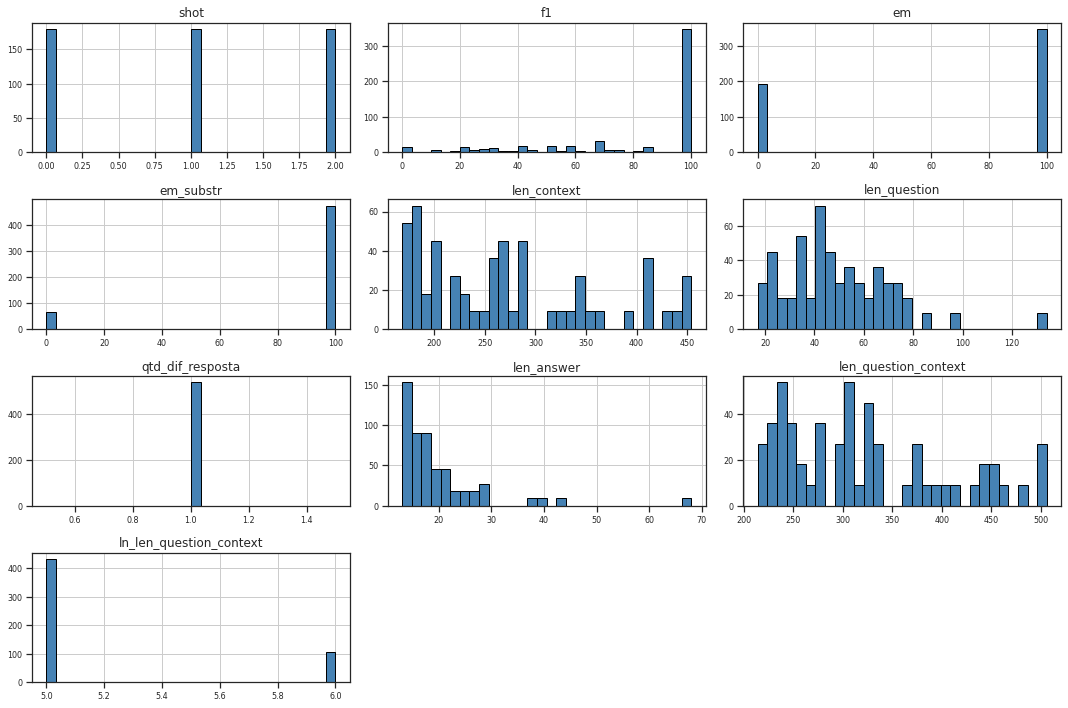

In [ ]:
# Histograma dos dados

fig, ax = plt.subplots(1, 1, figsize=(15,10))
ax.set_title('Histograma dos dados')
df_resultado.hist(bins=30, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=True, ax=ax)  
plt.tight_layout()   

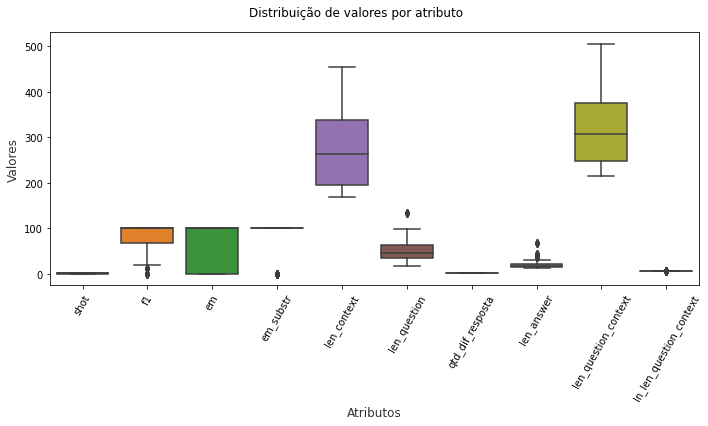

In [33]:
f, ax = plt.subplots(1, 1, figsize=figsize)
f.suptitle('Distribuição de valores por atributo')

sns.boxplot( data=df_resultado,  ax=ax)
ax.set_xlabel("Atributos",size = 12,alpha=0.8)
ax.set_ylabel("Valores",size = 12,alpha=0.8)
plt.xticks(rotation=60)
plt.tight_layout()

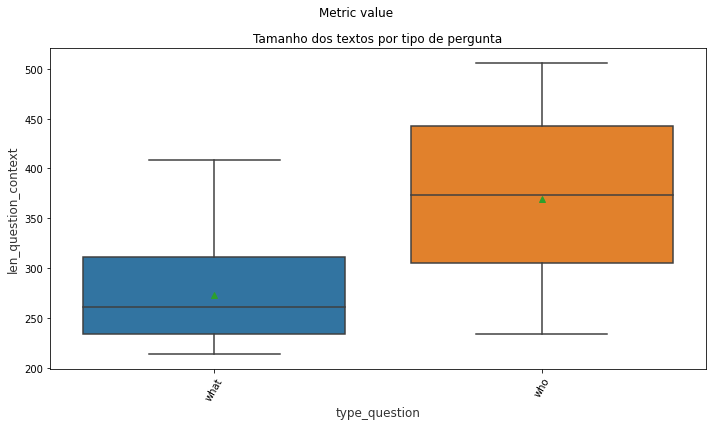

In [38]:
f, ax = plt.subplots(1, 1, figsize=figsize)
f.suptitle('Metric value')

sns.boxplot(x="type_question", y="len_question_context", data=df_resultado, showmeans=True, ax=ax)
ax.set_xlabel("type_question",size = 12,alpha=0.8)
ax.set_ylabel("len_question_context",size = 12,alpha=0.8)
ax.set_title('Tamanho dos textos por tipo de pergunta')

plt.xticks(rotation=60)
plt.tight_layout()

#### Observações (sobre distribuição de valores)

Pode-se perceber que o EM_Substr trouxe como positivo (100%) um grande número de EM=0 (próximo de 150*).

Na seleção de perguntas, poucas foram as respostas que tiveram* mais de 30 caracteres (o máximo de 66) e as perguntas do tipo "who" tiveram um tamanho superior (pergunta e contexto), na média, às perguntas do tipo "what" (cerca de 200* caracteres).

O F1 alcançou em sua grande maioria 100%. Mas há alguns poucos registros distribuídos em outros valores. Isso sinaliza que as respostas ficaram dentro do esperado. Acredito que o ChatGPT assumiu a maior parte desses valores menores de F1, já que, por ser  prolixo, sua precisão (parte da fórmula do F1) é prejudicada. 

* Número apurado visualmente nos gráficos, a ser confirmado nos dados.

### Análise por modelo

In [40]:
lista_nome_metrica = ['f1', 'em', 'em_substr']

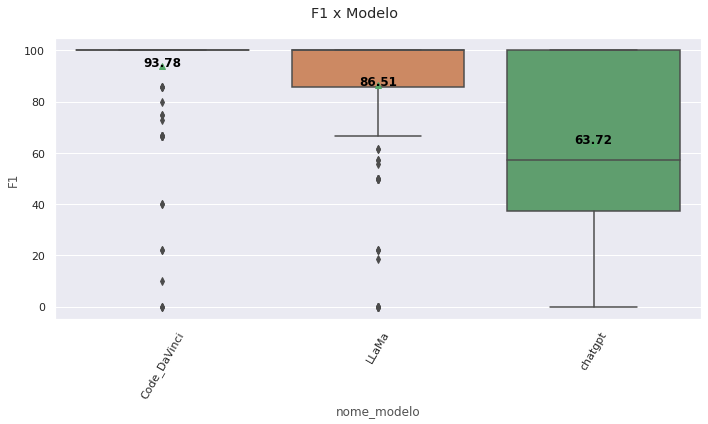

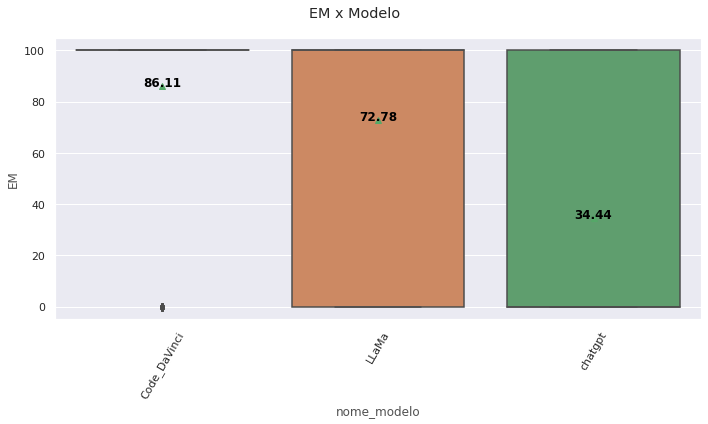

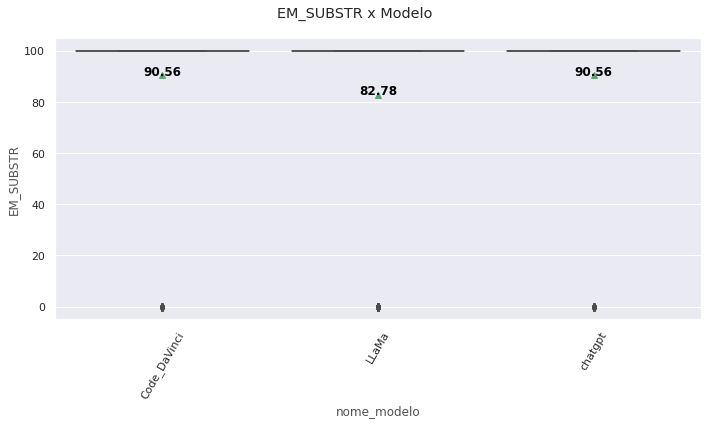

In [ ]:
# ordenar o DataFrame pelo nome do modelo
df_resultado_sorted = df_resultado.sort_values('nome_modelo')

for metrica in lista_nome_metrica:
  f, ax = plt.subplots(1, 1, figsize=figsize)
  f.suptitle(f'{metrica.upper()} x Modelo')
  ax.tick_params(axis='x', rotation=90)

  sns.boxplot(x="nome_modelo", y=metrica, data=df_resultado_sorted, showmeans=True,  ax=ax)
  ax.set_xlabel("nome_modelo",size = 12,alpha=0.8)
  ax.set_ylabel(f"{metrica.upper()}", size = 12,alpha=0.8)
  plt.xticks(rotation=60)
  plt.tight_layout()

  # adicionar o label da média
  means = df_resultado_sorted.groupby('nome_modelo')[metrica].mean().values
  for i, tick in enumerate(ax.get_xticklabels()):
      ax.text(i, means[i], f"{means[i]:.2f}", horizontalalignment='center', size='medium', color='black', weight='semibold')
  
  # exibir o gráfico
  plt.show()


#### Observações (sobre os modelos)

. O F1 do Code_DaVinci ficou bem superior aos demais (93,78%), mas acredito que o ChatGPT, por ser  prolixo, foi prejudicado, visto que sua precisão (parte da fórmula do F1) é prejudicada. 

. O EM do ChatGPT foi prejudicado também por esse motivo.

. Interessante ter agregado a métrica EM_Substr que considera como 100% se o a resposta dada contiver a resposta esperada. Dessa forma foi feito justiça ao "prolixo" ChatGPT. Claro que uma engenharia de prompt ou fine-tunning poderiam ser experimentados para retirar essas sobras de palavras.

. Nessa nova métrica proposta (EM_Substr), todos os modelos se saíram bem. Com uma diferença de 8 pontos para os modelos da OpenAi.

### Analise por número de exemplos (shots)

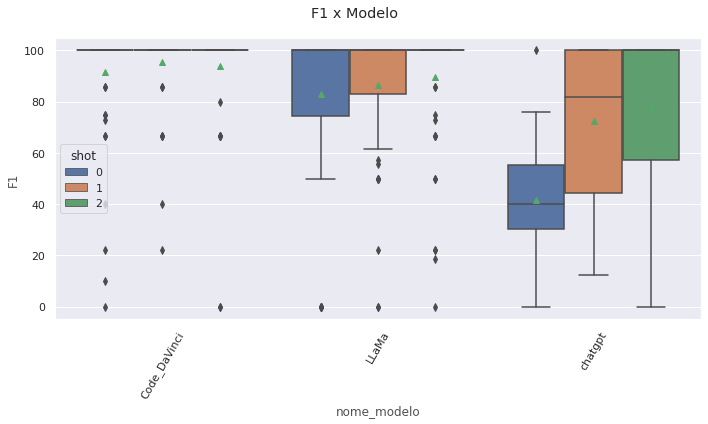

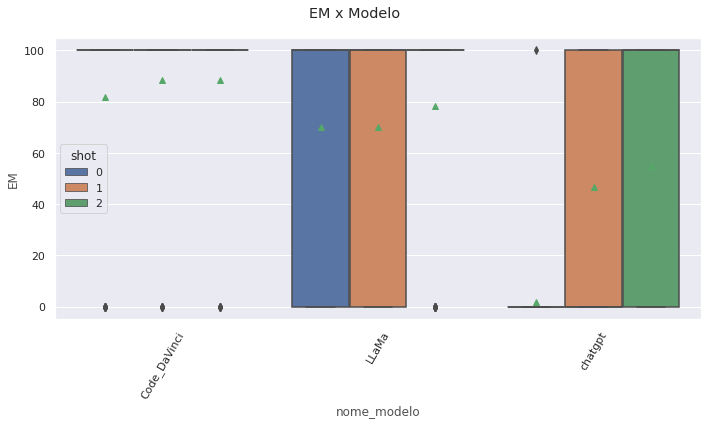

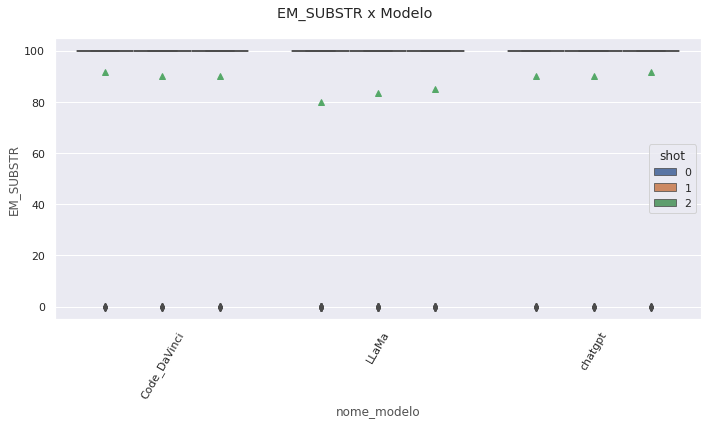

In [ ]:
# ordenar o DataFrame pelo nome do modelo
df_resultado_sorted = df_resultado.sort_values('nome_modelo')
for metrica in lista_nome_metrica:
    f, ax = plt.subplots(1, 1, figsize=figsize)
    f.suptitle(f'{metrica.upper()} x Modelo')
    ax.tick_params(axis='x', rotation=90)


    sns.boxplot(x="nome_modelo", y=metrica, hue='shot', data=df_resultado_sorted, showmeans=True, ax=ax)
    ax.set_xlabel("nome_modelo", size=12, alpha=0.8)
    ax.set_ylabel(f"{metrica.upper()}", size=12, alpha=0.8)
    plt.xticks(rotation=60)
    plt.tight_layout()

    # exibir o gráfico
    plt.show()

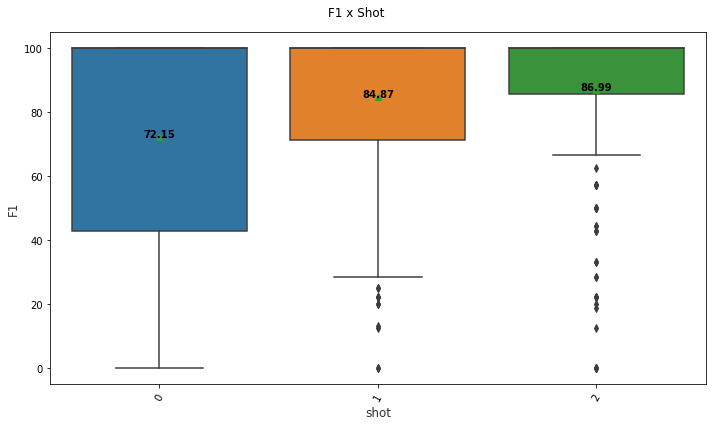

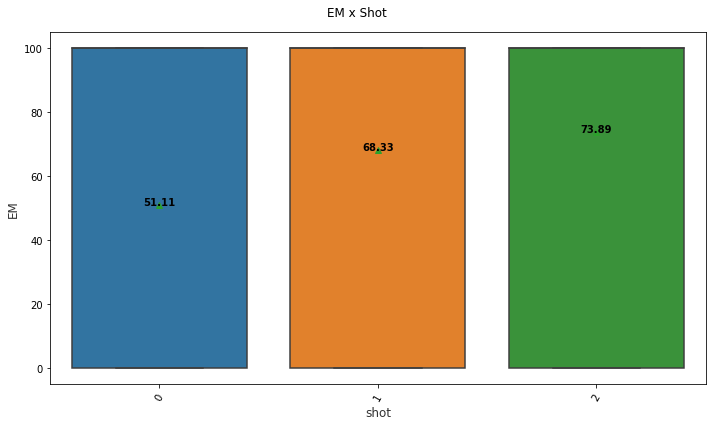

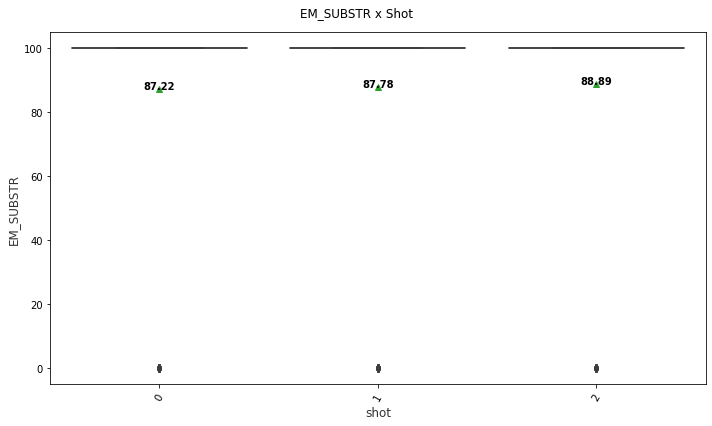

In [41]:
# ordenar o DataFrame pelo nome do modelo
df_resultado_sorted = df_resultado.sort_values('shot')
for metrica in lista_nome_metrica:
  f, ax = plt.subplots(1, 1, figsize=figsize)
  f.suptitle(f'{metrica.upper()} x Shot')
  ax.tick_params(axis='x', rotation=90)



  sns.boxplot(x="shot", y=metrica, data=df_resultado_sorted, showmeans=True,  ax=ax)
  ax.set_xlabel("shot",size = 12,alpha=0.8)
  ax.set_ylabel(f"{metrica.upper()}", size = 12,alpha=0.8)
  plt.xticks(rotation=60)
  plt.tight_layout()

  # adicionar o label da média
  means = df_resultado_sorted.groupby('shot')[metrica].mean().values
  for i, tick in enumerate(ax.get_xticklabels()):
      ax.text(i, means[i], f"{means[i]:.2f}", horizontalalignment='center', size='medium', color='black', weight='semibold')
  
  # exibir o gráfico
  plt.show()

#### Observações (sobre o número de exemplos)

. Em média, os modelos foram melhor com 2-shot em todas as métricas apuradas.

. ChatGPT foi o que melhor respondeu ao aumento do número de exemplos (de 1 para 2).
. o Code_DaVinci foi o que pior respondeu em relação ao uso de exemplos contra 0-shot (houve até decréscimo no EM_Substr).

### Análise por tipo de questão

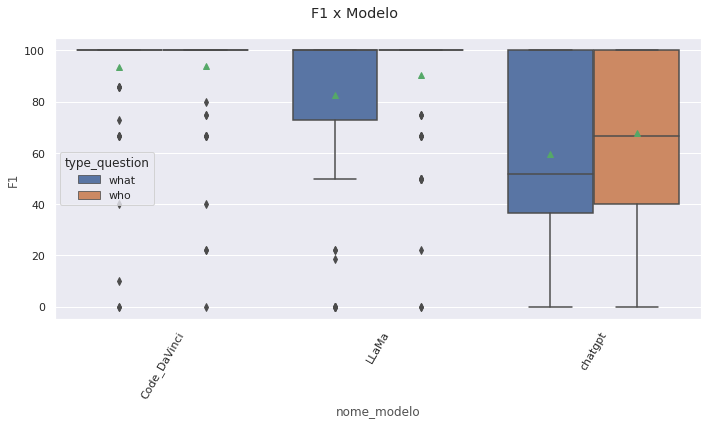

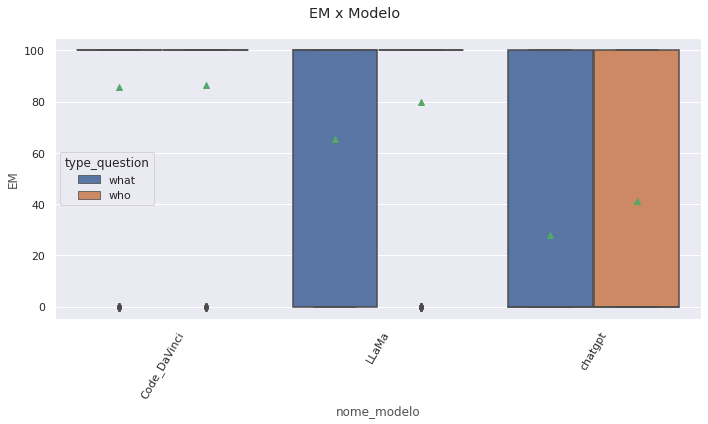

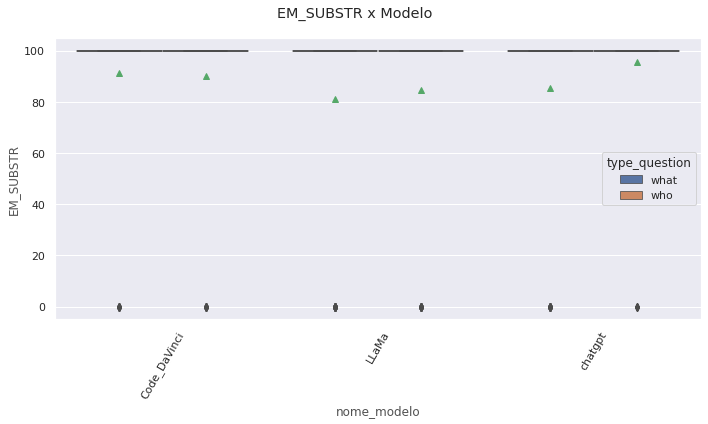

In [ ]:
# ordenar o DataFrame pelo nome do modelo
df_resultado_sorted = df_resultado.sort_values('nome_modelo')
for metrica in lista_nome_metrica:
    f, ax = plt.subplots(1, 1, figsize=figsize)
    f.suptitle(f'{metrica.upper()} x Modelo')
    ax.tick_params(axis='x', rotation=90)



    sns.boxplot(x="nome_modelo", y=metrica, hue='type_question', data=df_resultado_sorted, showmeans=True, ax=ax)
    ax.set_xlabel("nome_modelo", size=12, alpha=0.8)
    ax.set_ylabel(f"{metrica.upper()}", size=12, alpha=0.8)
    plt.xticks(rotation=60)
    plt.tight_layout()

    # exibir o gráfico
    plt.show()


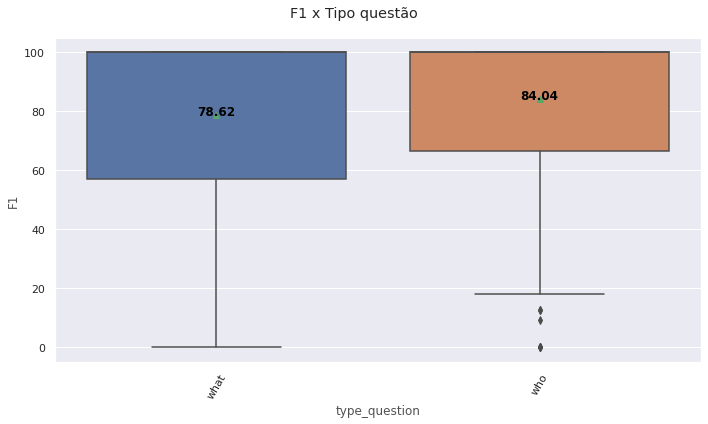

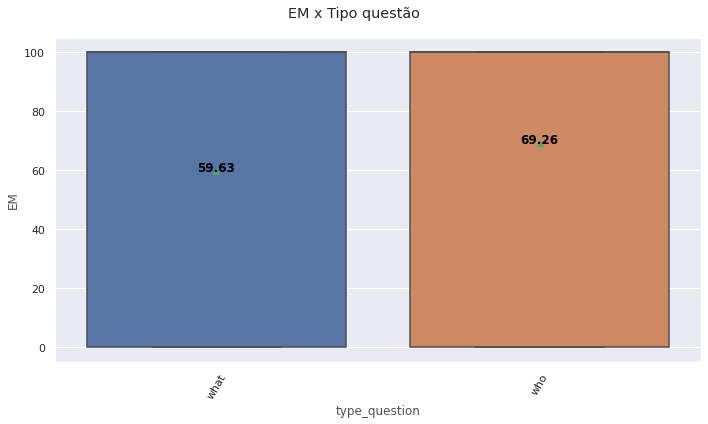

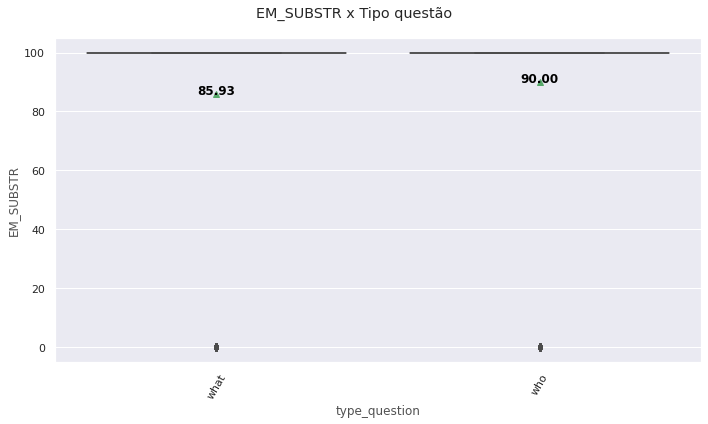

In [ ]:
# ordenar o DataFrame pelo nome do modelo
df_resultado_sorted = df_resultado.sort_values('type_question')
for metrica in lista_nome_metrica:
  f, ax = plt.subplots(1, 1, figsize=figsize)
  f.suptitle(f'{metrica.upper()} x Tipo questão')
  ax.tick_params(axis='x', rotation=90)

  sns.boxplot(x="type_question", y=metrica, data=df_resultado_sorted, showmeans=True,  ax=ax)
  ax.set_xlabel("type_question",size = 12,alpha=0.8)
  ax.set_ylabel(f"{metrica.upper()}", size = 12,alpha=0.8)
  plt.xticks(rotation=60)
  plt.tight_layout()

  # adicionar o label da média
  means = df_resultado_sorted.groupby('type_question')[metrica].mean().values
  for i, tick in enumerate(ax.get_xticklabels()):
      ax.text(i, means[i], f"{means[i]:.2f}", horizontalalignment='center', size='medium', color='black', weight='semibold')
  
  # exibir o gráfico
  plt.show()

#### Observações (sobre o tipo de questão)

. Em média, os modelos foram melhores nas perguntas do tipo "who" do que nas do tipo "what". A métrica mais sensível foi a EM (10 pontos), indicando que o "what" pode a uma maior prolixidade.
 
. o Code_DaVinci foi o menos sensível ao tipo da pergunta (houve até decréscimo no EM_Substr).

### Análise por número de caracteres no contexto e na pergunta (log natural)

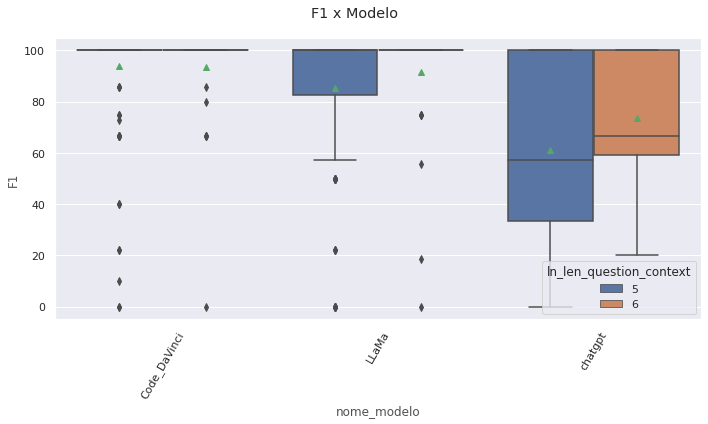

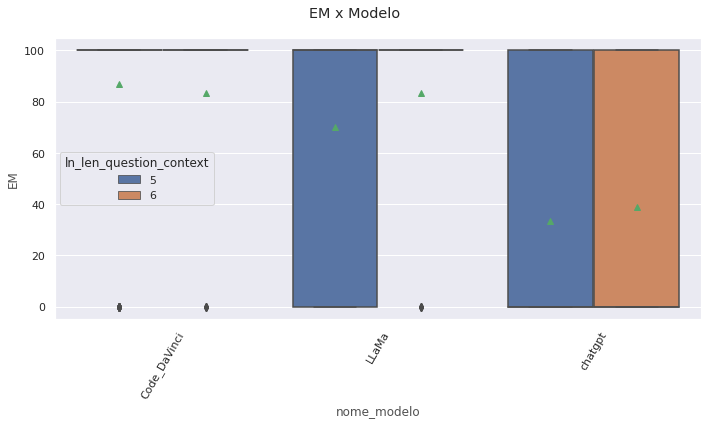

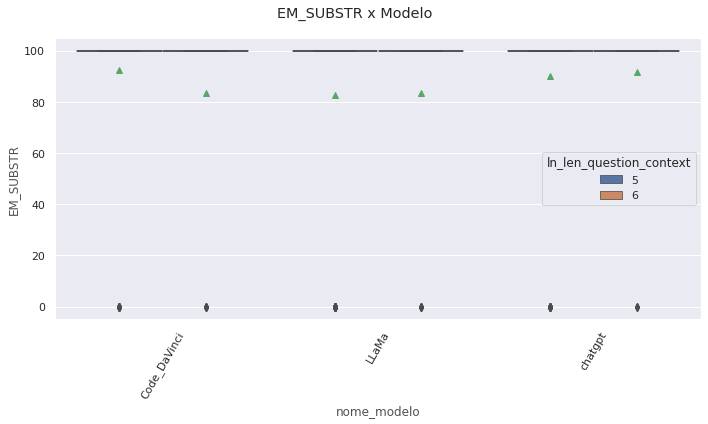

In [ ]:
# ordenar o DataFrame pelo nome do modelo
df_resultado_sorted = df_resultado.sort_values('nome_modelo')
for metrica in lista_nome_metrica:
    f, ax = plt.subplots(1, 1, figsize=figsize)
    f.suptitle(f'{metrica.upper()} x Modelo')
    ax.tick_params(axis='x', rotation=90)

    sns.boxplot(x="nome_modelo", y=metrica, hue='ln_len_question_context', data=df_resultado_sorted, showmeans=True, ax=ax)
    ax.set_xlabel("nome_modelo", size=12, alpha=0.8)
    ax.set_ylabel(f"{metrica.upper()}", size=12, alpha=0.8)
    plt.xticks(rotation=60)
    plt.tight_layout()

    # exibir o gráfico
    plt.show()



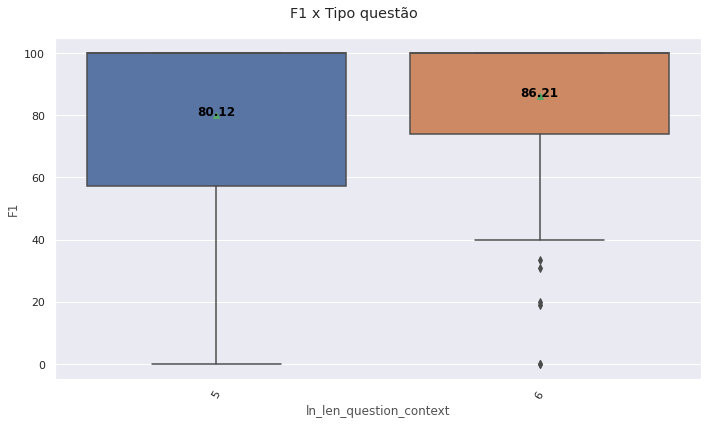

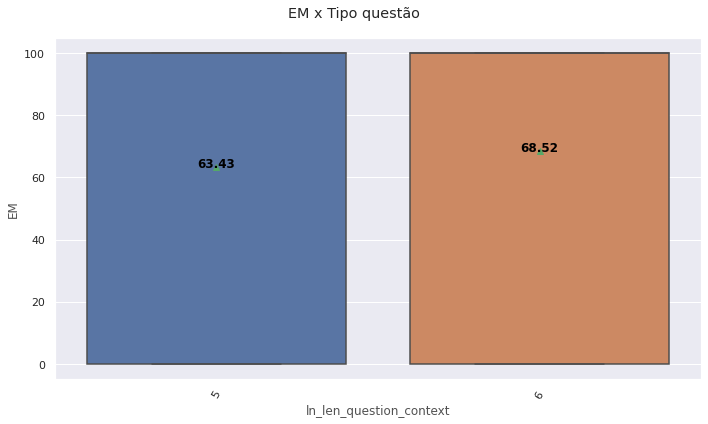

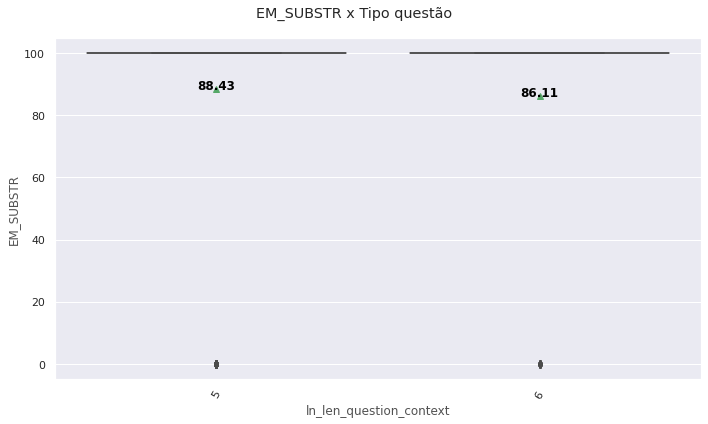

In [ ]:

# ordenar o DataFrame pelo nome do modelo
df_resultado_sorted = df_resultado.sort_values('ln_len_question_context')
for metrica in lista_nome_metrica:
  f, ax = plt.subplots(1, 1, figsize=figsize)
  f.suptitle(f'{metrica.upper()} x Tipo questão')
  ax.tick_params(axis='x', rotation=90)


  sns.boxplot(x="ln_len_question_context", y=metrica, data=df_resultado_sorted, showmeans=True,  ax=ax)
  ax.set_xlabel("ln_len_question_context",size = 12,alpha=0.8)
  ax.set_ylabel(f"{metrica.upper()}", size = 12,alpha=0.8)
  plt.xticks(rotation=60)
  plt.tight_layout()

  # adicionar o label da média
  means = df_resultado_sorted.groupby('ln_len_question_context')[metrica].mean().values
  for i, tick in enumerate(ax.get_xticklabels()):
      ax.text(i, means[i], f"{means[i]:.2f}", horizontalalignment='center', size='medium', color='black', weight='semibold')
  
  # exibir o gráfico
  plt.show()

#### Observações (sobre o tamanho da descrição: pergunta + contexto)

. Apenas o Code_DaVinci foi pior nas respostas para descrições maiores nas métricas. Os outros dois acertaram mais com descrições maiores. Esse é um bom ponto a ser investigado.

### Correlações diversas

In [ ]:
corr = df_resultado.corr()

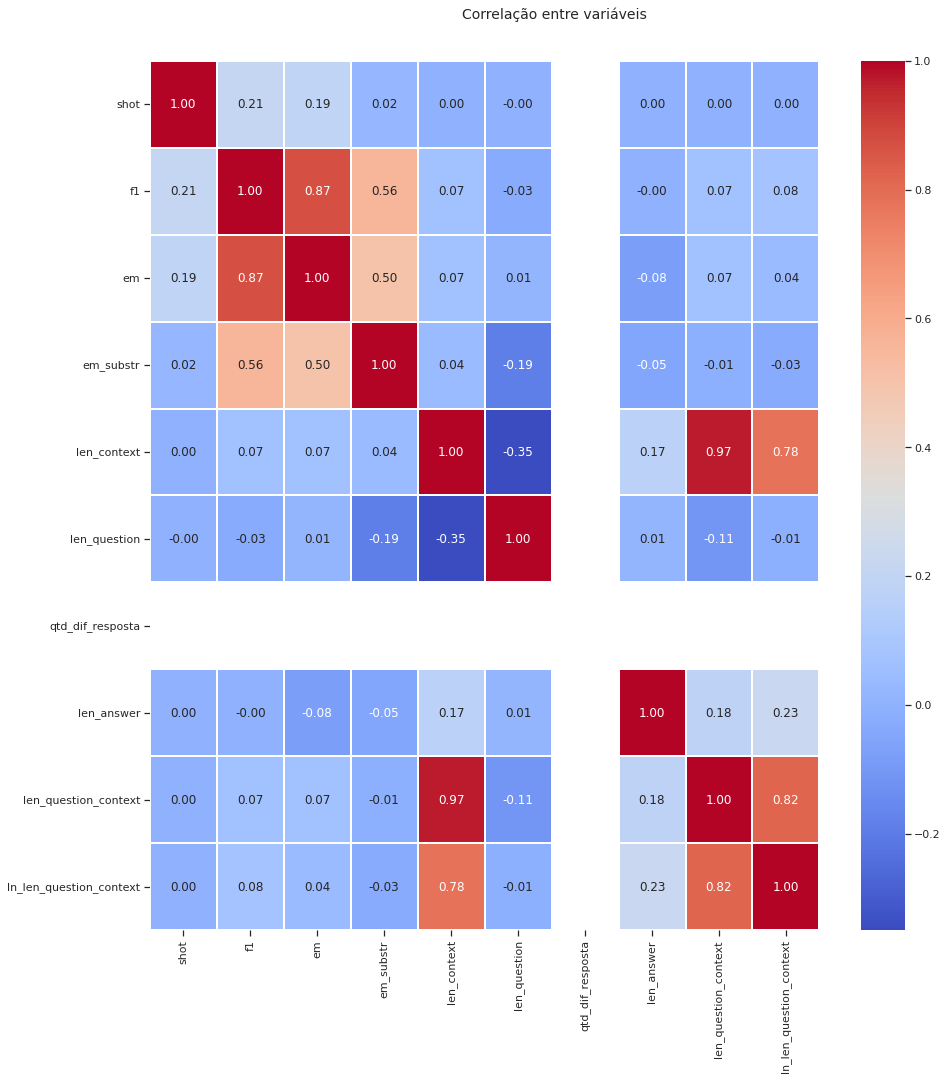

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Correlação entre variáveis', fontsize=14)

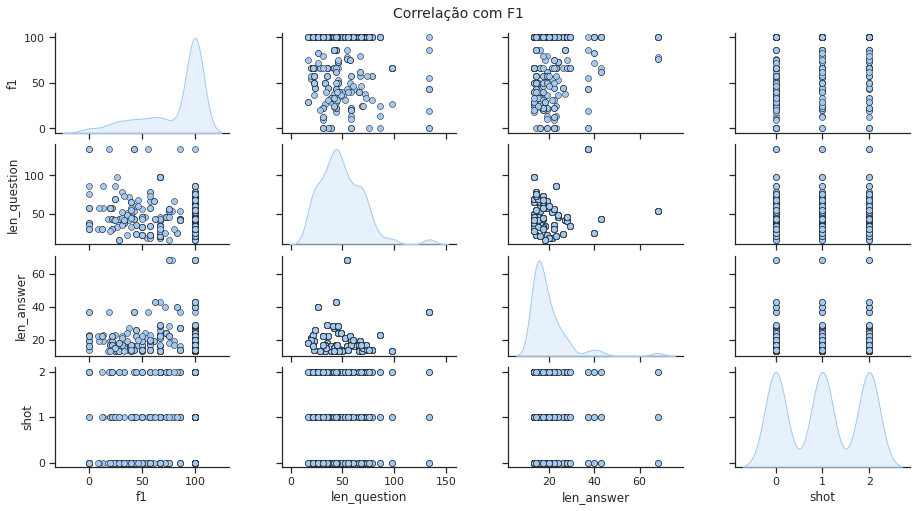

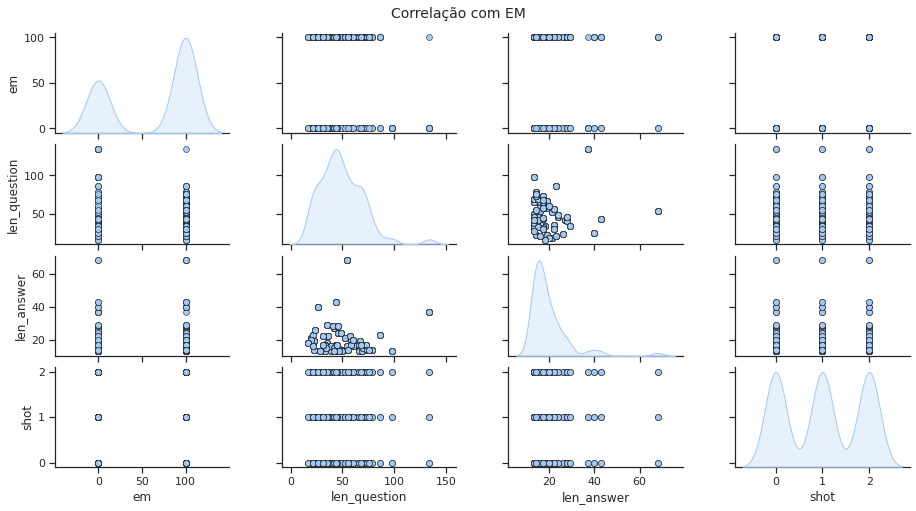

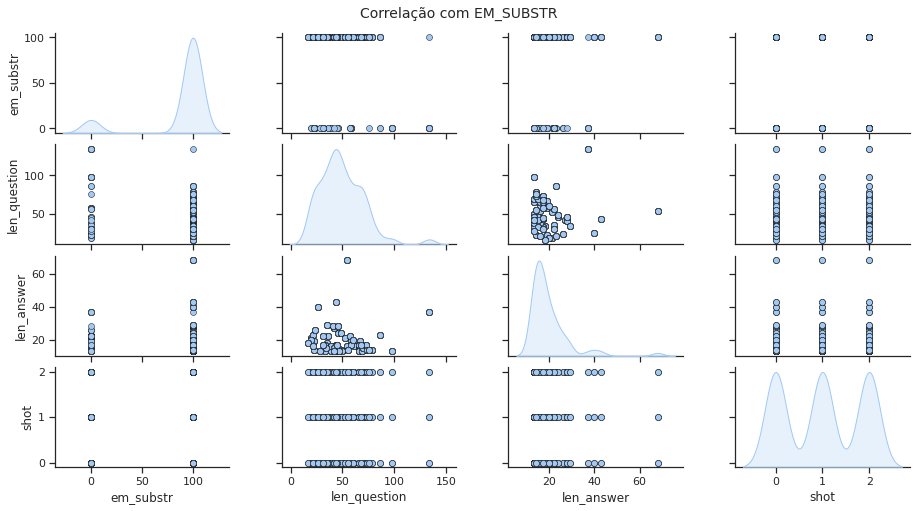

In [ ]:
# Correlação entre dados

#aspect = quanto largura maior do que altura
# diag_kind = kede formato mais arredondado
for metrica in lista_nome_metrica:
  pp = sns.pairplot(df_resultado[[ metrica,'len_question',
        'len_answer', 'shot']], height=1.8, aspect=1.8,
                    plot_kws=dict(edgecolor="k", linewidth=0.5),
                    diag_kind="kde", diag_kws=dict(fill=True))

  fig = pp.fig 
  fig.subplots_adjust(top=0.93, wspace=0.3)
  t = fig.suptitle(f'Correlação com {metrica.upper()}', fontsize=14)

#### Observações (sobre correlações)

. Aparentemente a métrica proposta EM_Substr tem uma correlação com o tamanho da resposta e co o tamanho da pergunta. Em relação ao tamanho da resposta, justifica o aumento pois aumenta a chance de englobar a resposta certa.

. As métricas possuem uma certa correlação entre si. A métrica EM_Substr tem maior correlação com a F1 do que com a EM. É compreensível pois a F1 traduz melhor textos semelhantes nas duas respostas.

### Gráfico do projeto [exqa-complearning Extractive Q&A - Performance Comparison between Learning Methods: Context and Transfer](https://github.com/marcusborela/exqa-complearning)

Final Project at Discipline IA025, Introdução ao Aprendizado Profundo, Turma A  
Authors: Leonardo Augusto da Silva Pacheco e Marcus Vinícius Borela de Castro   
Teachers: Roberto de Alencar Lotufo e Rodrigo Frassetto Nogueira 

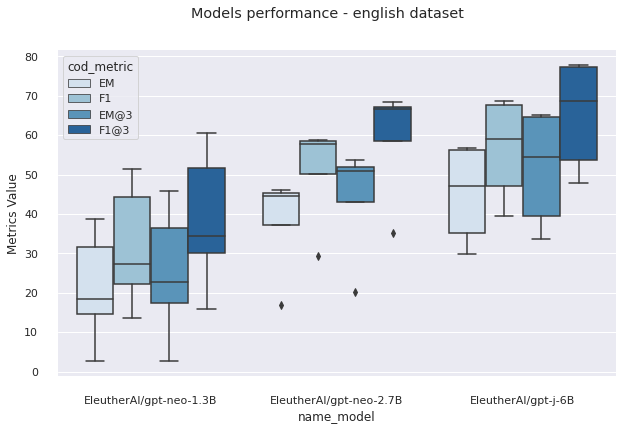

#### Observações (comparando com o trabalho anterior)

. Percebe-se um sensível aumento nos valores das métricas para os novos modelos, dada sua maior capacidade (treinamento realizado e número de parâmetros).

. A métrica F1 aumentou até 43 pontos percentuais: passou de 58 (gpt-j-6B) para 93,78 (Code_DaVinci) e 86,51 (LLaMa).

. A EM aumentou até 38 pontos percentuais: passou de 48 (gpt-j-6B) para 86,11 (Code_DaVinci) e 72,78 (LLaMa).

. O impacto maior na F1 é justificado pois os modelos podem responder mais palavras do que o esperado. Por isso, a métrica proposta EM_Substr se mostra uma boa alternativa nessas comparações. Mas não havia esses valores no projeto anterior, até porque os modelos foram testados no arcabouço pipeline"text-generation" da library transformer.

. Fica para tabalho futuro uma análise mais detalhada: restrita às perguntas selecionadas neste trabalho e trazendo também para a comparação resultados do modelo distilbert-base-cased-distilled-squad.

# Observações finais

Para o Code_DaVinci precisei colocar um sleep (20 segundos) devido a erro de estouro do limite de chamadas por minuto. Fiquei na dúvida: esse limite é porque ele é gratuito? Será que existe também para versões pagas como o  ChatGPT (para ele usei 5 segundos). Mas não testei limites.

Propusemos métrica EM_Substr em detrimento à métrica EM (Exact_Match) para tratar possibilidade da resposta dada conter a resposta ground thruth, já que o chatgpt acrescenta informações na sua resposta (prolixo!). Há que se avaliar se assegurar que essas informações acrescidas são verdadeiras.

